# BaseLine Transformer

Caution: This is not a usual use case of Transformer.

Transformer developed by Google usually use Embeddeding Layer to represents a target such as a word.

In this model, I use OHLC as a state vector though we can take same approch for finance data.
As d_model is very low, this would be a base line of Transformer.

Parameters:
- Input:  ohlc_df.iloc[index] while observation length
- Target: ohlc_df.iloc[index+observation_length] while prediction length

In [3]:
import csv
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

f:\d_drive\workspace\stocknet_study\venv_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  base_folder = "/Data/FX"
  data_folder = f'/content/drive/My Drive{base_folder}'
else:
  base_folder = '../../../Data/'
  data_folder = base_folder

In [5]:
if IS_GOOGLE_COLAB:
    from google.colab import drive

class Logger:
  
  @classmethod
  def connect_drive(cls, mount_path='/content/drive'):
    drive.mount(mount_path)

  def __init__(self, base_path=None, model_name=None, file_name=None, colab=False, max_retry=3):
    # define common veriables
    MOUNT_PATH = '/content/drive'
    if file_name is None:
      file_name = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")

    # define variables depends on env
    if colab:
      drive.mount(MOUNT_PATH)
      if base_path is None:
        self.base_path = MOUNT_PATH
      else:
        base_pathes = [p for p in base_path.split('/') if len(p) > 0]
        self.base_path = os.path.join(MOUNT_PATH, 'My Drive', *base_pathes)
    else:
      if base_path is None:
        self.base_path = './'
      else:
        self.base_path = base_path
    if model_name is None:
      self.log_file_path = os.path.join(self.base_path, file_name)      
    else:
      model_log_folder = os.path.join(self.base_path, model_name)
      if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
      self.log_file_path = os.path.join(model_log_folder, file_name)

    self.max_retry = max_retry
    self.__cache = []

  def reset(self, model_name=None, file_name=None):
    if file_name is None:
      file_name = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    if model_name is None:
      self.log_file_path = os.path.join(self.base_path, file_name)
    else:
      model_log_folder = os.path.join(self.base_path, model_name)
      if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
      self.log_file_path = os.path.join(model_log_folder, file_name)
    self.__cache = []

  def __append_to_log(self, log_entry:list, retry_count=0):
      try:
          with open(self.log_file_path, 'a') as log_file:
            while len(self.__cache) > 0:
              cache_log = self.__cache[0]
              writer = csv.writer(log_file)
              writer.writerow(cache_log)
              self.__cache.remove(0)
            writer = csv.writer(log_file)
            writer.writerow(log_entry)
      except Exception as e:
        if retry_count < self.max_retry:
          if retry_count == 0:
            print(e)
          drive.mount('/content/drive')
          self.__append_to_log(log_entry, retry_count+1)
        else:
          self.__cache.append(log_entry)
          
  def save_params(self, params:dict, model_name, model_version):
    data_folder = os.path.dirname(self.log_file_path)
    param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}_params.json')
    with open(param_file_path, mode="w") as fp:
      json.dump(params, fp)
    
  def save_model(self, model, model_name, model_version):
    data_folder = os.path.dirname(self.log_file_path)
    param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
    torch.save(model.state_dict(), param_file_path)

  def add_training_log(self, training_loss, validation_loss, log_entry:list=None):
    timestamp = datetime.now().isoformat()
    basic_entry = [timestamp, training_loss, validation_loss]
    if log_entry is not None:
      if type(log_entry) is list and len(log_entry) > 0:
        basic_entry.extend(log_entry)
    self.__append_to_log(basic_entry)

In [43]:
if IS_GOOGLE_COLAB:
    Logger.connect_drive()
    module_path = os.path.abspath("/content/drive/My Drive/modules")
    sys.path.append(module_path)
    import fprocess
else:
    module_path = os.path.abspath("../..")
    sys.path.append(module_path)
    from fprocess import fprocess

# Basic Transformer model

In [53]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [54]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(feature_size, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self, src: Tensor, tgt: Tensor, mask_tgt: Tensor,
        mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [55]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, tgt=input_tgt,  mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [56]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)

        logits = model(
            src=src, tgt=input_tgt, mask_tgt=mask_tgt,
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Row Data

Since we shouldn't expose data obtained from other service, csv is not committed to this repository.
Please preprare your data and load it.

In [9]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_name = "mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder, 'fx', 'OANDA-Japan MT5 Live', file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


### Training

In [59]:
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [60]:
from Dataset.transformer import FeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_transfomer"
model_version = "1"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = FeatureDataset(df, columns, processes=processes,
             observation_length=observation_length, prediction_length=prediction_length, device=device)

In [61]:
feature_size = 4

# Hyper parameters
nhead = 1
dim_feedforward = 20
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

params = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params += p.numel()
print(f"params: {params}")

model = model.to(device)

params: 1296


In [63]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [64]:
log_file_name = f"{model_name}_v{model_version}.csv"
logger = Logger(data_folder, model_name, log_file_name)
        
params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ../../../Data/finance_basic_transfomer\finance_basic_transfomer_v1.csv


In [65]:
epoch = 500
best_train_loss = float('Inf')
best_valid_loss = float('Inf')
best_model = None
best_train_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_valid else ''
    )
    print(log)
    logger.add_training_log(loss_train, loss_valid, elapsed_time)
    
    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_model(best_train_model, f'{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_model(best_model, model_name, model_version)
        
    if counter > patience:
        break

logger.save_model(best_train_model, f'{model_name}_train', model_version)
logger.save_model(best_model, model_name, model_version)

  0%|          | 0/1258 [00:00<?, ?it/s]

100%|██████████| 1258/1258 [08:32<00:00,  2.45it/s]


[1/500] train loss: 0.2878593516, valid loss: 0.0322868704  33s] count: 0, **


100%|██████████| 1258/1258 [07:53<00:00,  2.66it/s]


[2/500] train loss: 0.0075988367, valid loss: 0.0013292557  54s] count: 0, **


100%|██████████| 1258/1258 [07:33<00:00,  2.78it/s]


[3/500] train loss: 0.0015590783, valid loss: 0.0012869510  33s] count: 0, **


100%|██████████| 1258/1258 [07:28<00:00,  2.81it/s]


[4/500] train loss: 0.0015163485, valid loss: 0.0012893584  28s] count: 0, 


100%|██████████| 1258/1258 [07:53<00:00,  2.65it/s]


[5/500] train loss: 0.0015017740, valid loss: 0.0012866473  54s] count: 0, **


100%|██████████| 1258/1258 [07:37<00:00,  2.75it/s]


[6/500] train loss: 0.0014978966, valid loss: 0.0012864099  37s] count: 0, **


100%|██████████| 1258/1258 [07:20<00:00,  2.86it/s]


[7/500] train loss: 0.0014930701, valid loss: 0.0012869491  21s] count: 0, 


100%|██████████| 1258/1258 [07:20<00:00,  2.86it/s]


[8/500] train loss: 0.0014904803, valid loss: 0.0012860340  21s] count: 0, **


100%|██████████| 1258/1258 [07:05<00:00,  2.95it/s]


[9/500] train loss: 0.0014894710, valid loss: 0.0012842779  6s] count: 0, **


100%|██████████| 1258/1258 [07:10<00:00,  2.92it/s]


[10/500] train loss: 0.0014891542, valid loss: 0.0012868439  10s] count: 0, 


100%|██████████| 1258/1258 [07:34<00:00,  2.77it/s]


[11/500] train loss: 0.0014883467, valid loss: 0.0012844162  35s] count: 0, 


100%|██████████| 1258/1258 [07:33<00:00,  2.78it/s]


[12/500] train loss: 0.0014881855, valid loss: 0.0012845811  33s] count: 0, 


100%|██████████| 1258/1258 [07:12<00:00,  2.91it/s]


[13/500] train loss: 0.0014895764, valid loss: 0.0012853095  13s] count: 0, 


100%|██████████| 1258/1258 [07:16<00:00,  2.88it/s]


[14/500] train loss: 0.0014875626, valid loss: 0.0012843775  16s] count: 1, 


100%|██████████| 1258/1258 [07:50<00:00,  2.67it/s]


[15/500] train loss: 0.0014871292, valid loss: 0.0012735428  50s] count: 0, **


100%|██████████| 1258/1258 [07:54<00:00,  2.65it/s]


[16/500] train loss: 0.0014795607, valid loss: 0.0012302668  55s] count: 0, **


100%|██████████| 1258/1258 [07:50<00:00,  2.68it/s]


[17/500] train loss: 0.0014613341, valid loss: 0.0011929684  50s] count: 0, **


100%|██████████| 1258/1258 [07:38<00:00,  2.74it/s]


[18/500] train loss: 0.0014299596, valid loss: 0.0011349480  39s] count: 0, **


100%|██████████| 1258/1258 [07:10<00:00,  2.92it/s]


[19/500] train loss: 0.0014142072, valid loss: 0.0011262149  11s] count: 0, **


100%|██████████| 1258/1258 [07:25<00:00,  2.82it/s]


[20/500] train loss: 0.0014069591, valid loss: 0.0011113157  26s] count: 0, **


100%|██████████| 1258/1258 [07:23<00:00,  2.83it/s]


[21/500] train loss: 0.0014018407, valid loss: 0.0011201017  24s] count: 0, 


100%|██████████| 1258/1258 [07:16<00:00,  2.88it/s]


[22/500] train loss: 0.0013922725, valid loss: 0.0010808734  17s] count: 0, **


100%|██████████| 1258/1258 [07:14<00:00,  2.90it/s]


[23/500] train loss: 0.0013832722, valid loss: 0.0010883990  14s] count: 0, 


100%|██████████| 1258/1258 [07:46<00:00,  2.69it/s]


[24/500] train loss: 0.0013777127, valid loss: 0.0010944972  47s] count: 0, 


100%|██████████| 1258/1258 [08:16<00:00,  2.54it/s]


[25/500] train loss: 0.0013683686, valid loss: 0.0010793021  16s] count: 0, **


100%|██████████| 1258/1258 [08:16<00:00,  2.53it/s]


[26/500] train loss: 0.0013607594, valid loss: 0.0010744296  16s] count: 0, **


100%|██████████| 1258/1258 [08:38<00:00,  2.43it/s]


[27/500] train loss: 0.0013524098, valid loss: 0.0010684581  39s] count: 0, **


100%|██████████| 1258/1258 [07:55<00:00,  2.65it/s]


[28/500] train loss: 0.0013483408, valid loss: 0.0010581142  55s] count: 0, **


100%|██████████| 1258/1258 [08:07<00:00,  2.58it/s]


[29/500] train loss: 0.0013454202, valid loss: 0.0010787128  7s] count: 0, 


100%|██████████| 1258/1258 [07:47<00:00,  2.69it/s]


[30/500] train loss: 0.0013421207, valid loss: 0.0010774480  47s] count: 0, 


100%|██████████| 1258/1258 [07:37<00:00,  2.75it/s]


[31/500] train loss: 0.0013400302, valid loss: 0.0010612592  37s] count: 0, 


100%|██████████| 1258/1258 [07:47<00:00,  2.69it/s]


[32/500] train loss: 0.0013374645, valid loss: 0.0010497715  48s] count: 0, **


100%|██████████| 1258/1258 [07:38<00:00,  2.74it/s]


[33/500] train loss: 0.0013332115, valid loss: 0.0010433923  39s] count: 0, **


100%|██████████| 1258/1258 [07:54<00:00,  2.65it/s]


[34/500] train loss: 0.0013304695, valid loss: 0.0010755939  55s] count: 0, 


100%|██████████| 1258/1258 [07:26<00:00,  2.82it/s]


[35/500] train loss: 0.0013286648, valid loss: 0.0010665377  27s] count: 0, 


100%|██████████| 1258/1258 [07:18<00:00,  2.87it/s]


[36/500] train loss: 0.0013278741, valid loss: 0.0010416432  18s] count: 0, **


100%|██████████| 1258/1258 [07:57<00:00,  2.63it/s]


[37/500] train loss: 0.0013240765, valid loss: 0.0010553583  58s] count: 0, 


100%|██████████| 1258/1258 [08:10<00:00,  2.56it/s]


[38/500] train loss: 0.0013226680, valid loss: 0.0010584972  11s] count: 0, 


100%|██████████| 1258/1258 [08:52<00:00,  2.36it/s]


[39/500] train loss: 0.0013210745, valid loss: 0.0010612842  53s] count: 0, 


100%|██████████| 1258/1258 [08:52<00:00,  2.36it/s]


[40/500] train loss: 0.0013181602, valid loss: 0.0010412223  53s] count: 0, **


100%|██████████| 1258/1258 [08:56<00:00,  2.35it/s]


[41/500] train loss: 0.0013177384, valid loss: 0.0010556528  56s] count: 0, 


100%|██████████| 1258/1258 [08:49<00:00,  2.38it/s]


[42/500] train loss: 0.0013162245, valid loss: 0.0011004657  49s] count: 0, 


100%|██████████| 1258/1258 [08:49<00:00,  2.38it/s]


[43/500] train loss: 0.0013127935, valid loss: 0.0010811351  50s] count: 0, 


100%|██████████| 1258/1258 [08:56<00:00,  2.34it/s]


[44/500] train loss: 0.0013111482, valid loss: 0.0010969877  57s] count: 0, 


100%|██████████| 1258/1258 [09:03<00:00,  2.31it/s]


[45/500] train loss: 0.0013077715, valid loss: 0.0011023357  4s] count: 0, 


100%|██████████| 1258/1258 [09:02<00:00,  2.32it/s]


[46/500] train loss: 0.0013044715, valid loss: 0.0011580058  2s] count: 0, 


100%|██████████| 1258/1258 [09:00<00:00,  2.33it/s]


[47/500] train loss: 0.0013019209, valid loss: 0.0011611743  0s] count: 0, 


100%|██████████| 1258/1258 [09:11<00:00,  2.28it/s]


[48/500] train loss: 0.0013006195, valid loss: 0.0012047267  11s] count: 0, 


100%|██████████| 1258/1258 [08:38<00:00,  2.43it/s]


[49/500] train loss: 0.0012960395, valid loss: 0.0012585302  39s] count: 0, 


100%|██████████| 1258/1258 [08:51<00:00,  2.37it/s]


[50/500] train loss: 0.0012931017, valid loss: 0.0013405917  51s] count: 0, 


100%|██████████| 1258/1258 [08:30<00:00,  2.47it/s]


[51/500] train loss: 0.0012879161, valid loss: 0.0012453299  30s] count: 0, 


100%|██████████| 1258/1258 [08:31<00:00,  2.46it/s]


[52/500] train loss: 0.0012860621, valid loss: 0.0012858426  32s] count: 0, 


100%|██████████| 1258/1258 [09:22<00:00,  2.24it/s]


[53/500] train loss: 0.0012832901, valid loss: 0.0013342881  23s] count: 0, 


100%|██████████| 1258/1258 [09:08<00:00,  2.29it/s]


[54/500] train loss: 0.0012817604, valid loss: 0.0013494067  9s] count: 0, 


100%|██████████| 1258/1258 [08:58<00:00,  2.34it/s]


[55/500] train loss: 0.0012780871, valid loss: 0.0014294601  59s] count: 0, 


100%|██████████| 1258/1258 [09:09<00:00,  2.29it/s]


[56/500] train loss: 0.0012753571, valid loss: 0.0014356081  10s] count: 0, 


100%|██████████| 1258/1258 [09:04<00:00,  2.31it/s]


[57/500] train loss: 0.0012735670, valid loss: 0.0013883453  4s] count: 0, 


100%|██████████| 1258/1258 [09:08<00:00,  2.30it/s]


[58/500] train loss: 0.0012718603, valid loss: 0.0013967592  8s] count: 0, 


100%|██████████| 1258/1258 [08:52<00:00,  2.36it/s]


[59/500] train loss: 0.0012691118, valid loss: 0.0015004607  52s] count: 0, 


100%|██████████| 1258/1258 [08:57<00:00,  2.34it/s]


[60/500] train loss: 0.0012679006, valid loss: 0.0015145385  58s] count: 0, 


100%|██████████| 1258/1258 [08:37<00:00,  2.43it/s]


[61/500] train loss: 0.0012666324, valid loss: 0.0014396549  38s] count: 0, 


100%|██████████| 1258/1258 [08:47<00:00,  2.39it/s]


[62/500] train loss: 0.0012652977, valid loss: 0.0015243594  47s] count: 0, 


100%|██████████| 1258/1258 [08:26<00:00,  2.49it/s]


[63/500] train loss: 0.0012639994, valid loss: 0.0015174869  26s] count: 0, 


100%|██████████| 1258/1258 [09:47<00:00,  2.14it/s]


[64/500] train loss: 0.0012624921, valid loss: 0.0014778188  48s] count: 0, 


100%|██████████| 1258/1258 [08:39<00:00,  2.42it/s]


[65/500] train loss: 0.0012627089, valid loss: 0.0016281222  40s] count: 0, 


100%|██████████| 1258/1258 [07:45<00:00,  2.70it/s]


[66/500] train loss: 0.0012598806, valid loss: 0.0015828860  45s] count: 1, 


100%|██████████| 1258/1258 [07:36<00:00,  2.75it/s]


[67/500] train loss: 0.0012585633, valid loss: 0.0015747827  37s] count: 0, 


100%|██████████| 1258/1258 [08:35<00:00,  2.44it/s]


[68/500] train loss: 0.0012553891, valid loss: 0.0015443005  35s] count: 0, 


100%|██████████| 1258/1258 [08:05<00:00,  2.59it/s]


[69/500] train loss: 0.0012538688, valid loss: 0.0015426066  6s] count: 0, 


100%|██████████| 1258/1258 [07:38<00:00,  2.75it/s]


[70/500] train loss: 0.0012536951, valid loss: 0.0015489945  38s] count: 0, 


100%|██████████| 1258/1258 [07:03<00:00,  2.97it/s]


[71/500] train loss: 0.0012522972, valid loss: 0.0016339952  3s] count: 0, 


100%|██████████| 1258/1258 [07:12<00:00,  2.91it/s]


[72/500] train loss: 0.0012508178, valid loss: 0.0016229610  13s] count: 0, 


100%|██████████| 1258/1258 [07:00<00:00,  2.99it/s]


[73/500] train loss: 0.0012505789, valid loss: 0.0015810105  0s] count: 0, 


100%|██████████| 1258/1258 [07:48<00:00,  2.69it/s]


[74/500] train loss: 0.0012484384, valid loss: 0.0015689055  48s] count: 0, 


100%|██████████| 1258/1258 [08:23<00:00,  2.50it/s]


[75/500] train loss: 0.0012493429, valid loss: 0.0015885194  24s] count: 0, 


100%|██████████| 1258/1258 [07:23<00:00,  2.84it/s]


[76/500] train loss: 0.0012461742, valid loss: 0.0015358403  24s] count: 1, 


100%|██████████| 1258/1258 [07:17<00:00,  2.88it/s]


[77/500] train loss: 0.0012472476, valid loss: 0.0016778283  17s] count: 0, 


100%|██████████| 1258/1258 [07:24<00:00,  2.83it/s]


[78/500] train loss: 0.0012466602, valid loss: 0.0016077177  24s] count: 1, 


100%|██████████| 1258/1258 [07:28<00:00,  2.81it/s]


[79/500] train loss: 0.0012451804, valid loss: 0.0015873205  28s] count: 2, 


100%|██████████| 1258/1258 [07:28<00:00,  2.81it/s]


[80/500] train loss: 0.0012447448, valid loss: 0.0016389967  28s] count: 0, 


100%|██████████| 1258/1258 [07:31<00:00,  2.79it/s]


[81/500] train loss: 0.0012443466, valid loss: 0.0016223803  31s] count: 0, 


100%|██████████| 1258/1258 [07:29<00:00,  2.80it/s]


[82/500] train loss: 0.0012436704, valid loss: 0.0016029320  30s] count: 0, 


100%|██████████| 1258/1258 [07:28<00:00,  2.81it/s]


[83/500] train loss: 0.0012419813, valid loss: 0.0015576790  28s] count: 0, 


100%|██████████| 1258/1258 [07:26<00:00,  2.82it/s]


[84/500] train loss: 0.0012429181, valid loss: 0.0015521693  27s] count: 0, 


100%|██████████| 1258/1258 [07:28<00:00,  2.80it/s]


[85/500] train loss: 0.0012424342, valid loss: 0.0015879980  29s] count: 1, 


100%|██████████| 1258/1258 [07:24<00:00,  2.83it/s]


[86/500] train loss: 0.0012415290, valid loss: 0.0016043765  25s] count: 2, 


100%|██████████| 1258/1258 [07:24<00:00,  2.83it/s]


[87/500] train loss: 0.0012421812, valid loss: 0.0015533704  25s] count: 0, 


100%|██████████| 1258/1258 [07:22<00:00,  2.84it/s]


[88/500] train loss: 0.0012407000, valid loss: 0.0015461934  23s] count: 1, 


100%|██████████| 1258/1258 [07:30<00:00,  2.79it/s]


[89/500] train loss: 0.0012409618, valid loss: 0.0015698599  30s] count: 0, 


100%|██████████| 1258/1258 [07:23<00:00,  2.84it/s]


[90/500] train loss: 0.0012412813, valid loss: 0.0017281166  23s] count: 1, 


100%|██████████| 1258/1258 [07:22<00:00,  2.84it/s]


[91/500] train loss: 0.0012412804, valid loss: 0.0015782303  23s] count: 2, 


100%|██████████| 1258/1258 [07:27<00:00,  2.81it/s]


[92/500] train loss: 0.0012395436, valid loss: 0.0016357716  28s] count: 3, 


100%|██████████| 1258/1258 [07:26<00:00,  2.82it/s]


[93/500] train loss: 0.0012396087, valid loss: 0.0015439182  27s] count: 0, 


100%|██████████| 1258/1258 [07:26<00:00,  2.82it/s]


[94/500] train loss: 0.0012387371, valid loss: 0.0016485996  27s] count: 1, 


100%|██████████| 1258/1258 [07:26<00:00,  2.81it/s]


[95/500] train loss: 0.0012388429, valid loss: 0.0016570198  27s] count: 0, 


100%|██████████| 1258/1258 [07:30<00:00,  2.79it/s]


[96/500] train loss: 0.0012399492, valid loss: 0.0016895492  31s] count: 1, 


100%|██████████| 1258/1258 [07:58<00:00,  2.63it/s]


[97/500] train loss: 0.0012382906, valid loss: 0.0016194292  58s] count: 2, 


100%|██████████| 1258/1258 [07:26<00:00,  2.82it/s]


[98/500] train loss: 0.0012367084, valid loss: 0.0016490077  26s] count: 0, 


100%|██████████| 1258/1258 [07:19<00:00,  2.86it/s]


[99/500] train loss: 0.0012381591, valid loss: 0.0015010432  20s] count: 0, 


100%|██████████| 1258/1258 [07:20<00:00,  2.85it/s]


[100/500] train loss: 0.0012372203, valid loss: 0.0016674862  21s] count: 1, 


100%|██████████| 1258/1258 [07:27<00:00,  2.81it/s]


[101/500] train loss: 0.0012384246, valid loss: 0.0016469380  28s] count: 2, 


100%|██████████| 1258/1258 [07:31<00:00,  2.79it/s]


[102/500] train loss: 0.0012381448, valid loss: 0.0016903485  32s] count: 3, 


In [ ]:
from google.colab import runtime

drive.flush_and_unmount()
runtime.unassign()

### Validation

In [66]:
model_version = 1
model.load_state_dict(torch.load(f'{data_folder}/{model_name}/{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [67]:
def prediction(inputs):

    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    while preds.size(0) <= prediction_length:
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, tgt=preds,  mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [80]:
ds.train()

src, tgt = ds[:16]

In [81]:
tgt_values = tgt.cpu().detach().numpy()
tgt_values.shape

(11, 16, 4)

In [82]:
src_values = src.cpu().detach().numpy()

In [83]:
from Dataset import revert_process

r_data = revert_process.revert(ds, src_values, [index for index in range(0, 16)], is_tgt=False)

In [84]:
# reverted open values
r_data[:, 0, 0]

array([102.73942, 102.60484, 102.64222, 102.44165, 102.33706, 102.40143,
       102.4758 , 102.37921, 102.37559, 102.32999, 102.38636, 102.32076,
       102.42312, 102.37652, 102.37091, 102.39428, 102.32569, 102.35306,
       102.44743, 102.44581, 102.53917, 102.49357, 102.41297, 102.35337,
       102.02184, 102.10021, 102.10659, 102.20295, 102.21134, 102.25671,
       102.33807, 102.31546, 102.28586, 102.18127, 102.29862, 102.37999,
       102.42136, 102.35876, 102.36515, 102.38453, 102.31093, 102.3783 ,
       102.40768, 102.19112, 102.26248, 102.10991, 102.38922, 102.4226 ,
       102.59094, 102.53734, 102.36777, 102.40614, 102.22457, 102.26195,
       102.21734, 102.20273, 102.03116, 101.99955, 102.12391, 102.19028])

In [85]:
index = ds.get_actual_index([0])[0]
df[ohlc_column].iloc[index:index+observation_length]

,open,high,low,close
time,,,,
2016-09-14 17:00:00,102.740,102.758,102.560,102.606
2016-09-14 17:30:00,102.606,102.659,102.515,102.644
2016-09-14 18:00:00,102.644,102.667,102.304,102.447
2016-09-14 18:30:00,102.444,102.465,102.330,102.341
2016-09-14 19:00:00,102.340,102.432,102.298,102.405
2016-09-14 19:30:00,102.405,102.491,102.371,102.480
2016-09-14 20:00:00,102.480,102.543,102.361,102.383
2016-09-14 20:30:00,102.384,102.411,102.342,102.381
2016-09-14 21:00:00,102.381,102.390,102.245,102.339


In [86]:
tgt_r_data = revert_process.revert(ds, tgt_values, [index for index in range(0, 16)], is_tgt=True)

In [87]:
# reverted open values
tgt_r_data[:, 0, 0]

array([102.22637, 102.14277, 102.12816, 102.05857, 102.06895, 102.04534,
       102.08971, 101.85416, 101.96052, 101.9769 , 101.81832])

In [91]:
index = ds.get_actual_index([0])[0]
df[ohlc_column].iloc[index+observation_length-1:index+observation_length+prediction_length]

,open,high,low,close
time,,,,
2016-09-15 22:30:00,102.227,102.230,102.131,102.145
2016-09-15 23:00:00,102.144,102.158,102.122,102.130
2016-09-15 23:30:00,102.130,102.142,102.074,102.076
2016-09-16 00:00:00,102.061,102.101,102.023,102.074
2016-09-16 00:30:00,102.072,102.087,102.025,102.036
2016-09-16 01:00:00,102.049,102.107,102.045,102.097
2016-09-16 01:30:00,102.094,102.103,101.735,101.858
2016-09-16 02:00:00,101.859,101.966,101.839,101.966
2016-09-16 02:30:00,101.966,102.019,101.929,101.981


In [93]:
ds.eval()
model.eval()

split_factor = 300
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp)
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = revert_process.revert(ds, pre_values, ndx, True)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans.cpu().detach().numpy()
    
    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [94]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 20060, 4) (11, 20060, 4)


[]

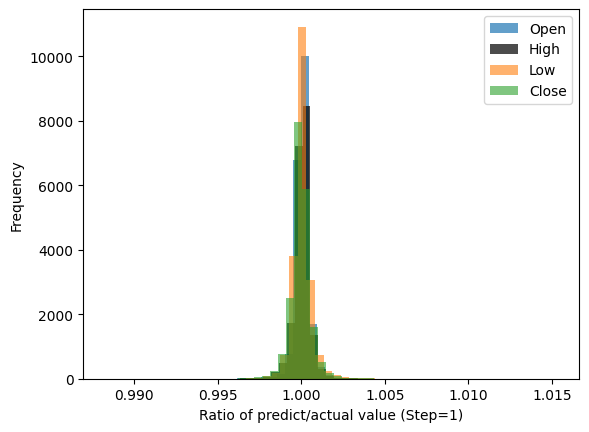

In [95]:
import matplotlib.pyplot as plt

step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

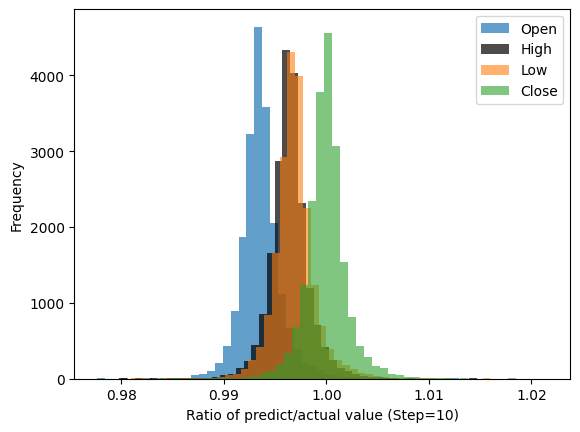

In [96]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [97]:
print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [1.      1.00007 0.99967 0.99933 0.99878 0.99824 0.99757 0.99663 0.99568
 0.99479 0.99362]
High [1.      1.00004 0.99983 0.99966 0.99937 0.99907 0.99869 0.99815 0.9976
 0.99709 0.9964 ]
Low [1.      1.00004 0.99988 0.99976 0.99953 0.9993  0.99899 0.99851 0.99802
 0.99758 0.99694]
Close [1.      0.99999 0.99998 0.99998 0.99997 0.99997 0.99996 0.99996 0.99996
 0.99996 0.99996]
==============Var============
Open [0.00000e+00 2.23486e-07 6.51621e-07 1.07628e-06 1.50165e-06 1.92786e-06
 2.36050e-06 2.80737e-06 3.26855e-06 3.73400e-06 4.22325e-06]
High [0.00000e+00 3.01617e-07 7.31594e-07 1.16995e-06 1.59980e-06 2.03014e-06
 2.45986e-06 2.88872e-06 3.32221e-06 3.76415e-06 4.20969e-06]
Low [0.00000e+00 3.64772e-07 8.36725e-07 1.30416e-06 1.75011e-06 2.19087e-06
 2.63185e-06 3.07415e-06 3.52531e-06 3.97463e-06 4.41908e-06]
Close [0.00000e+00 4.35964e-07 8.54391e-07 1.28965e-06 1.71577e-06 2.15267e-06
 2.58356e-06 3.02044e-06 3.46107e-06 3.89604e-06 4.33474e-

[]

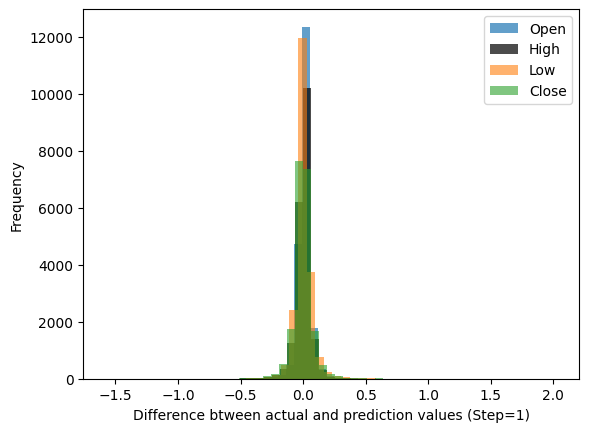

In [98]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

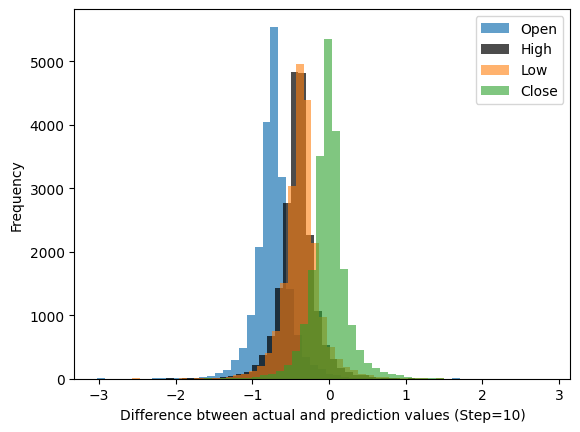

In [99]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [100]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.       0.00735 -0.03855 -0.07798 -0.1404  -0.20304 -0.28101 -0.38833
 -0.49858 -0.60142 -0.73583]
High [ 0.       0.00417 -0.01958 -0.03927 -0.07347 -0.1078  -0.15186 -0.21373
 -0.27748 -0.33647 -0.4151 ]
Low [ 0.       0.00407 -0.01355 -0.02781 -0.05452 -0.08136 -0.11727 -0.17168
 -0.22812 -0.27946 -0.35329]
Close [ 0.      -0.00132 -0.00212 -0.00299 -0.00359 -0.00419 -0.00461 -0.00469
 -0.00474 -0.00487 -0.00463]
==============Var============
Open [0.      0.00341 0.00988 0.01629 0.02272 0.02915 0.03566 0.04223 0.04887
 0.05548 0.06212]
High [0.      0.00457 0.01107 0.01772 0.02424 0.03078 0.03732 0.04382 0.05036
 0.05702 0.06363]
Low [0.      0.00552 0.01265 0.01971 0.02646 0.03315 0.03987 0.04662 0.05347
 0.06026 0.06691]
Close [0.      0.00657 0.01288 0.01945 0.02591 0.03254 0.03911 0.04579 0.05252
 0.05914 0.06584]


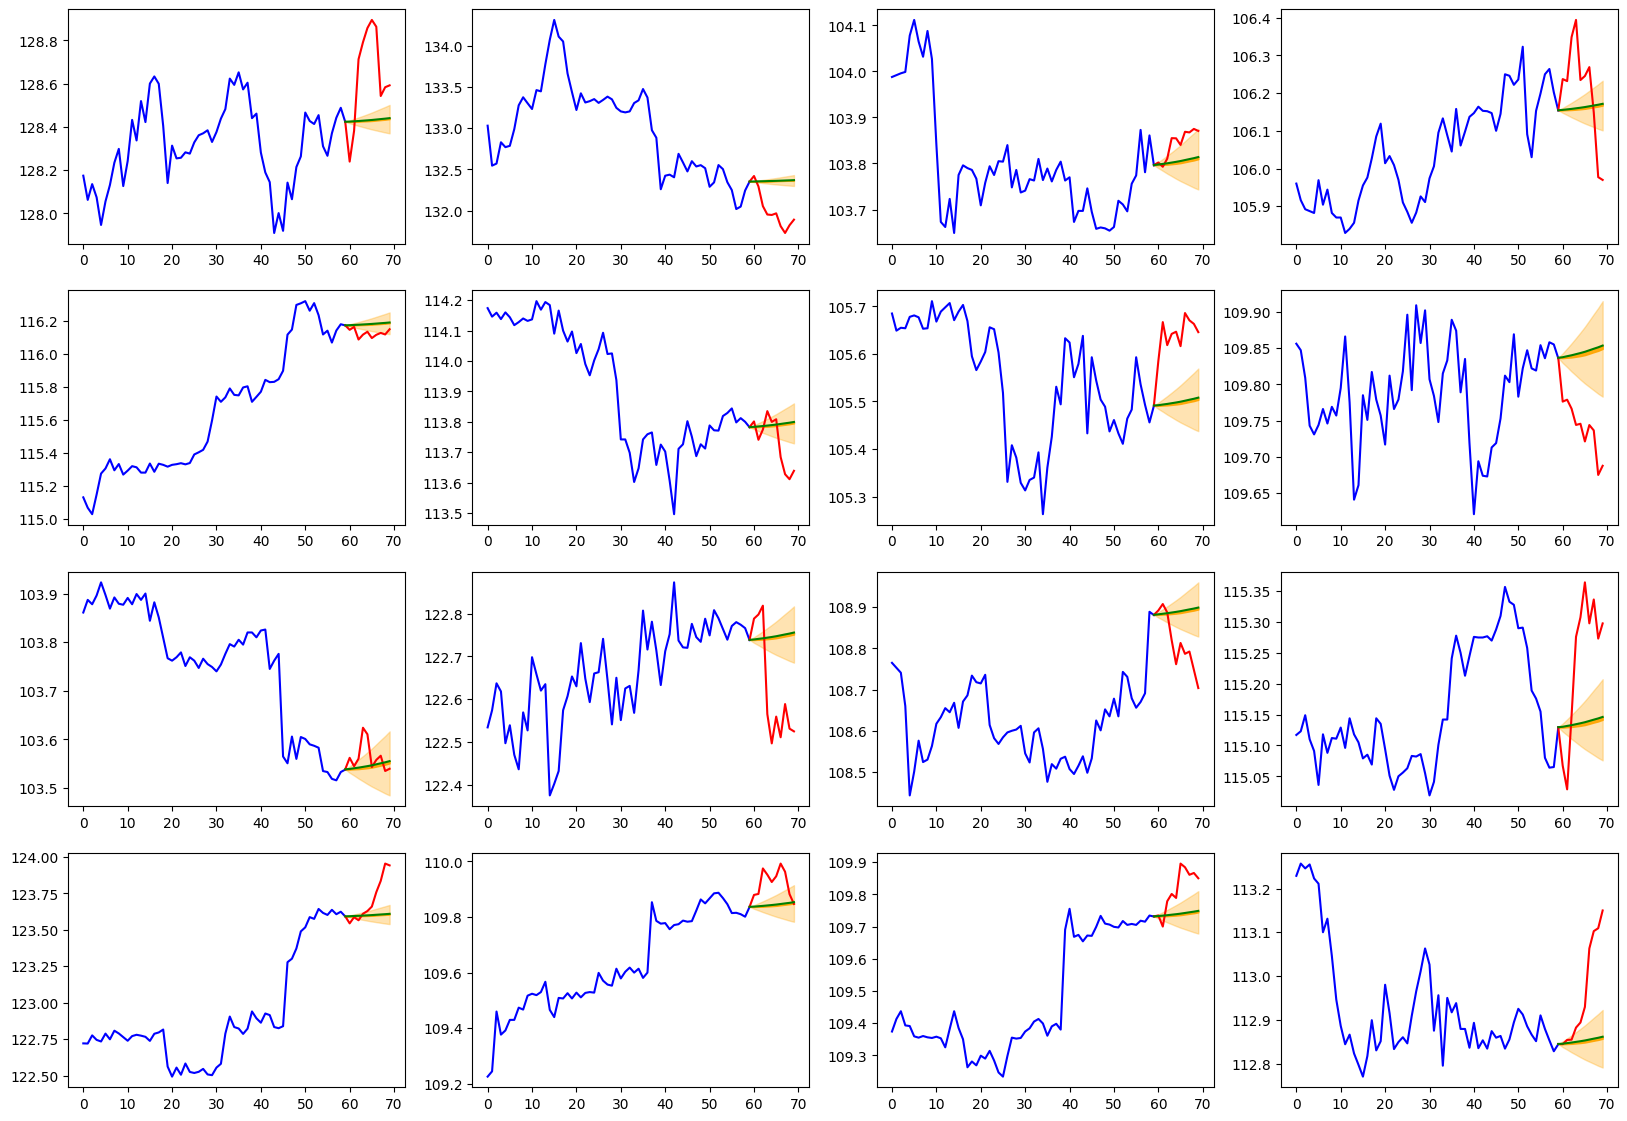

In [101]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

### Summary

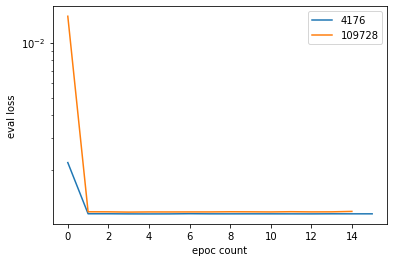

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

model_name = "finance_basic_transfomer"
logs_files = glob.glob(f"{data_folder}/{model_name}*_params.json")
logs_files = [log_file for log_file in logs_files if "ext" not in log_file]

eval_loss = []
eval_params = []

for log_file in logs_files:    
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".log")
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["level", "train_loss", "eval_loss", "time"]
    eval_params.append(params_num)
    eval_loss.append(logs.eval_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num)
plt.xlabel("epoc count")
plt.ylabel("eval loss")
plt.legend()
plt.show()

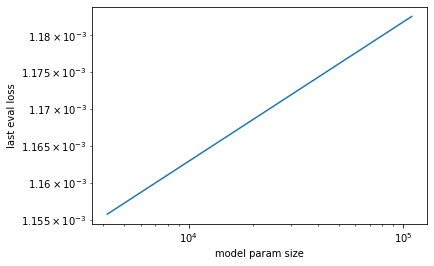

In [42]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("last eval loss")
plt.plot(eval_params, eval_loss)

## Row Data (More date range)

In [10]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [20]:
import pandas as pd
import glob

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_30MIN.zip"

if os.path.exists(file_path):
    df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
    file_path = f"{data_folder}/HistData_USDJPY_30MIN.csv"

    if os.path.exists(file_path):
        df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
        files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

        for file in files:
            min_df = read_histdata_file(file)
            rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
            rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
            rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
            rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
            rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
            rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
            rolled_df.dropna(inplace=True)
            df = pd.concat([df, rolled_df], axis=0)
        df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")
df

,open,high,low,close,volume
time,,,,,
2002-08-19 17:30:00,64.340,64.410,64.340,64.360,0
2002-08-19 18:00:00,64.350,64.500,64.350,64.430,0
2002-08-19 18:30:00,64.440,64.450,64.370,64.380,0
2002-08-19 19:00:00,64.380,64.430,64.370,64.410,0
2002-08-19 19:30:00,64.420,64.420,64.320,64.330,0
...,...,...,...,...,...
2022-12-30 14:30:00,130.952,131.020,130.925,130.971,0
2022-12-30 15:00:00,130.969,131.132,130.969,131.051,0
2022-12-30 15:30:00,131.050,131.291,130.996,131.269,0


### Training

In [21]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [22]:
from Dataset.transformer import FeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_transfomer"
model_version = "1"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = FeatureDataset(df, columns, processes=processes,
             observation_length=observation_length, prediction_length=prediction_length)

In [ ]:
feature_size = 4

# Hyper parameters
nhead = 1
dim_feedforward = 100
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [ ]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(f"params: {params}")
        
params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

In [ ]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    print(log)
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

### Summary

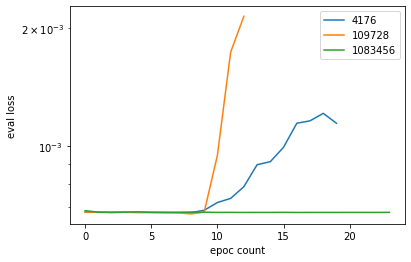

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

model_name = "finance_basic_transfomer_ext"
logs_files = glob.glob(f"{data_folder}/{model_name}_*_params.json")

eval_loss = []
eval_params = []

for log_file in logs_files:    
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".log")
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["level", "train_loss", "eval_loss", "time"]
    eval_params.append(params_num)
    eval_loss.append(logs.eval_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num)
plt.xlabel("epoc count")
plt.ylabel("eval loss")
plt.legend()
plt.show()

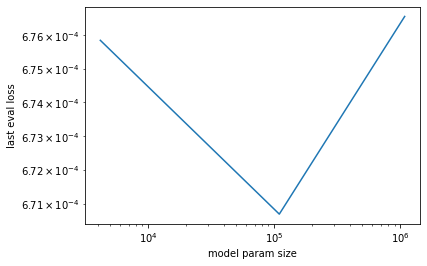

In [45]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("last eval loss")
plt.plot(eval_params, eval_loss)

## Summary

Increasing Data a bit improve the eval loss. But model size is irrelevant (or even minimum model size is too large).


In [19]:
ds.train()
train_date_range_row = ds.get_date_range()
train_length = len(ds)
ds.eval()
eval_date_range_row = ds.get_date_range()
eval_length = len(ds)
train_date_range_row, eval_date_range_row, train_length, eval_length

((Timestamp('2014-07-07 09:00:00'), Timestamp('2020-03-11 11:00:00')),
 (Timestamp('2020-03-12 22:30:00'), Timestamp('2022-08-11 12:30:00')),
 70454,
 30125)

In [23]:
ds.train()
train_date_range_ext = ds.get_date_range()
train_length_ext = len(ds)
ds.eval()
eval_date_range_ext = ds.get_date_range()
eval_length_ext = len(ds)
train_date_range_ext, eval_date_range_ext, train_length_ext, eval_length_ext

((Timestamp('2002-08-19 18:00:00'), Timestamp('2012-01-27 09:30:00')),
 (Timestamp('2012-01-30 23:00:00'), Timestamp('2022-12-29 05:30:00')),
 3626807,
 1554277)

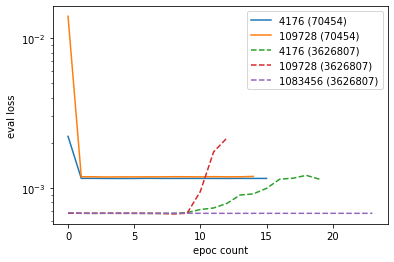

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

model_name = "finance_basic_transfomer"
logs_files = glob.glob(f"{data_folder}/{model_name}*_params.json")

row_eval_loss = []
row_eval_params = []
ext_eval_loss = []
ext_eval_params = []

for log_file in logs_files:
    if "ext" in log_file:
        is_extend_data = True
    else:
        is_extend_data = False
        
    with open(log_file) as fp:
        params = json.load(fp)
        label = str(params['params_num'])
    model_params = params['params_num']
    
    log_file = log_file.replace("_params.json", ".log")
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["level", "train_loss", "eval_loss", "time"]
    
    if is_extend_data:
        line_style = "--"
        length = str(train_length_ext)
        ext_eval_params.append(model_params)
        ext_eval_loss.append(logs.eval_loss.min())
    else:
        line_style = "-"
        length = f"{train_length}"
        row_eval_params.append(model_params)
        row_eval_loss.append(logs.eval_loss.min())
    label = f"{model_params} ({length})"
    plt.plot([*logs.index], logs.eval_loss, linestyle=line_style, label=label)
    
plt.yscale("log")
plt.xlabel("epoc count")
plt.ylabel("eval loss")
plt.legend()
plt.show()

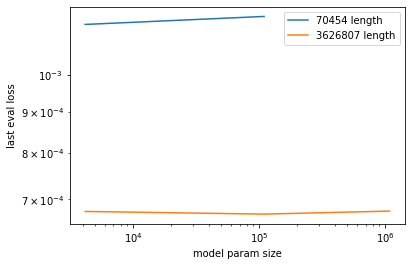

In [50]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("last eval loss")
plt.plot(row_eval_params, row_eval_loss, label=f"{train_length} length")
plt.plot(ext_eval_params, ext_eval_loss, label=f"{train_length_ext} length", linestyle="-")
plt.legend()
plt.show()

# BaseLine Transformer model with Weekly Time Position

Above results seems that predictions didn't learn the position. Not sure if that caused by different scale difference or lack of features.
Next model investigate it by changing positioning encoder from sin/cos of vector position to weekky hour position.
For example, if the steps is observed on [Monday 23:00, Monday 23:30, Thuesday 00:00, Thuesday 00:00], makes it as [47, 48, 49, 50] to represents the position of the step in the week. Then convert it to Embedded vector to add it with src and tgt.

In [33]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [34]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        self.dropout = nn.Dropout(dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_time = self.positional_encoding(src_time)
        src = self.dropout(torch.add(src, src_time))
        tgt_time = self.positional_encoding(tgt_time)
        tgt = self.dropout(torch.add(tgt, tgt_time))
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [35]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [36]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

### Row Data

In [105]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_name = "mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder,'fx', 'OANDA-Japan MT5 Live', file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


In [106]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq=30, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [107]:
from Dataset.transformer import TimeFeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold", device=device)

In [108]:
# check outputs represent (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    break
print(src[0].shape, src[1].shape) 
print(tgt[0].shape, tgt[1].shape)

torch.Size([60, 16, 4]) torch.Size([60, 16])
torch.Size([11, 16, 4]) torch.Size([11, 16])


#### Training

In [114]:
feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.01


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [115]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)

In [116]:
model_name = "finance_basic_wt_transfomer"
model_version = 1

log_file_name = f"{model_name}_v{model_version}.csv"
logger = Logger(data_folder, model_name, log_file_name)
        
params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ../../../Data/finance_basic_wt_transfomer\finance_basic_wt_transfomer_v1.csv


In [118]:
epoch = 500
best_train_loss = float('Inf')
best_valid_loss = float('Inf')
best_model = None
best_train_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_train else ''
    )
    print(log)
    logger.add_training_log(loss_train, loss_valid, elapsed_time)
    
    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_model(best_train_model, f'{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_model(best_model, model_name, model_version)
    
    if counter > patience:
        break

logger.save_model(best_train_model, f'{model_name}_train', model_version)
logger.save_model(best_model, model_name, model_version)

100%|█████████▉| 1258/1259 [09:20<00:00,  2.24it/s]


[1/500] train loss: 0.0068627673, valid loss: 0.0013344957  21s] count: 0, **


100%|█████████▉| 1258/1259 [08:43<00:00,  2.41it/s]


[2/500] train loss: 0.0015747275, valid loss: 0.0012578470  43s] count: 0, 


100%|█████████▉| 1258/1259 [09:15<00:00,  2.26it/s]


[3/500] train loss: 0.0015061756, valid loss: 0.0012208350  16s] count: 0, 


100%|█████████▉| 1258/1259 [09:20<00:00,  2.24it/s]


[4/500] train loss: 0.0014432435, valid loss: 0.0011549321  21s] count: 0, 


100%|█████████▉| 1258/1259 [09:25<00:00,  2.23it/s]


[5/500] train loss: 0.0013758671, valid loss: 0.0011030605  25s] count: 0, 


100%|█████████▉| 1258/1259 [09:29<00:00,  2.21it/s]


[6/500] train loss: 0.0013226145, valid loss: 0.0010774299  29s] count: 0, 


100%|█████████▉| 1258/1259 [09:17<00:00,  2.26it/s]


[7/500] train loss: 0.0012870006, valid loss: 0.0010570985  17s] count: 0, 


100%|█████████▉| 1258/1259 [08:31<00:00,  2.46it/s]


[8/500] train loss: 0.0012557088, valid loss: 0.0010300187  31s] count: 0, 


100%|█████████▉| 1258/1259 [08:54<00:00,  2.35it/s]


[9/500] train loss: 0.0012255228, valid loss: 0.0010005661  55s] count: 0, 


100%|█████████▉| 1258/1259 [08:31<00:00,  2.46it/s]


[10/500] train loss: 0.0011876928, valid loss: 0.0009623129  32s] count: 0, 


100%|█████████▉| 1258/1259 [08:15<00:00,  2.54it/s]


[11/500] train loss: 0.0011182759, valid loss: 0.0008547229  15s] count: 0, 


100%|█████████▉| 1258/1259 [08:16<00:00,  2.53it/s]


[12/500] train loss: 0.0010296808, valid loss: 0.0008350058  17s] count: 0, 


100%|█████████▉| 1258/1259 [08:04<00:00,  2.60it/s]


[13/500] train loss: 0.0010190650, valid loss: 0.0008293001  4s] count: 0, 


100%|█████████▉| 1258/1259 [07:54<00:00,  2.65it/s]


[14/500] train loss: 0.0010114718, valid loss: 0.0008214564  55s] count: 0, 


100%|█████████▉| 1258/1259 [08:13<00:00,  2.55it/s]


[15/500] train loss: 0.0010050601, valid loss: 0.0008162731  14s] count: 0, 


100%|█████████▉| 1258/1259 [07:40<00:00,  2.73it/s]


[16/500] train loss: 0.0010037592, valid loss: 0.0008197168  40s] count: 0, 


100%|█████████▉| 1258/1259 [08:59<00:00,  2.33it/s]


[17/500] train loss: 0.0009953066, valid loss: 0.0008170550  59s] count: 0, 


100%|█████████▉| 1258/1259 [09:31<00:00,  2.20it/s]


[18/500] train loss: 0.0009912071, valid loss: 0.0008125625  31s] count: 0, 


100%|█████████▉| 1258/1259 [09:32<00:00,  2.20it/s]


[19/500] train loss: 0.0009878686, valid loss: 0.0008123160  33s] count: 0, 


100%|█████████▉| 1258/1259 [08:58<00:00,  2.34it/s]


[20/500] train loss: 0.0009819067, valid loss: 0.0008060204  58s] count: 0, 


100%|█████████▉| 1258/1259 [08:40<00:00,  2.42it/s]


[21/500] train loss: 0.0009779420, valid loss: 0.0008016090  40s] count: 0, 


100%|█████████▉| 1258/1259 [08:48<00:00,  2.38it/s]


[22/500] train loss: 0.0009731575, valid loss: 0.0007985570  49s] count: 0, 


100%|█████████▉| 1258/1259 [09:16<00:00,  2.26it/s]


[23/500] train loss: 0.0009697710, valid loss: 0.0007982540  16s] count: 0, 


100%|█████████▉| 1258/1259 [08:47<00:00,  2.39it/s]


[24/500] train loss: 0.0009655703, valid loss: 0.0007982076  48s] count: 0, 


100%|█████████▉| 1258/1259 [08:56<00:00,  2.35it/s]


[25/500] train loss: 0.0009640365, valid loss: 0.0007922170  56s] count: 0, 


100%|█████████▉| 1258/1259 [08:59<00:00,  2.33it/s]


[26/500] train loss: 0.0009589690, valid loss: 0.0007914716  60s] count: 0, 


100%|█████████▉| 1258/1259 [08:50<00:00,  2.37it/s]


[27/500] train loss: 0.0009575030, valid loss: 0.0007899584  50s] count: 0, 


100%|█████████▉| 1258/1259 [08:44<00:00,  2.40it/s]


[28/500] train loss: 0.0009568027, valid loss: 0.0007881939  45s] count: 0, 


100%|█████████▉| 1258/1259 [08:32<00:00,  2.46it/s]


[29/500] train loss: 0.0009524086, valid loss: 0.0007871412  32s] count: 0, 


100%|█████████▉| 1258/1259 [07:54<00:00,  2.65it/s]


[30/500] train loss: 0.0009497359, valid loss: 0.0007842335  55s] count: 0, 


100%|█████████▉| 1258/1259 [07:36<00:00,  2.75it/s]


[31/500] train loss: 0.0009504872, valid loss: 0.0007840870  37s] count: 0, 


100%|█████████▉| 1258/1259 [08:10<00:00,  2.56it/s]


[32/500] train loss: 0.0009474460, valid loss: 0.0007868332  11s] count: 1, 


100%|█████████▉| 1258/1259 [09:20<00:00,  2.25it/s]


[33/500] train loss: 0.0009468344, valid loss: 0.0007821772  20s] count: 0, 


100%|█████████▉| 1258/1259 [08:56<00:00,  2.34it/s]


[34/500] train loss: 0.0009452390, valid loss: 0.0007807029  57s] count: 0, 


100%|█████████▉| 1258/1259 [08:48<00:00,  2.38it/s]


[35/500] train loss: 0.0009442998, valid loss: 0.0007781679  49s] count: 0, 


100%|█████████▉| 1258/1259 [09:06<00:00,  2.30it/s]


[36/500] train loss: 0.0009425146, valid loss: 0.0007785123  6s] count: 0, 


100%|█████████▉| 1258/1259 [09:40<00:00,  2.17it/s]


[37/500] train loss: 0.0009427261, valid loss: 0.0007763131  41s] count: 0, 


100%|█████████▉| 1258/1259 [09:30<00:00,  2.20it/s]


[38/500] train loss: 0.0009425592, valid loss: 0.0007796940  31s] count: 1, 


100%|█████████▉| 1258/1259 [09:31<00:00,  2.20it/s]


[39/500] train loss: 0.0009397266, valid loss: 0.0007767500  32s] count: 2, 


100%|█████████▉| 1258/1259 [09:54<00:00,  2.11it/s] 


[40/500] train loss: 0.0009404775, valid loss: 0.0007756253  55s] count: 0, 


100%|█████████▉| 1258/1259 [09:31<00:00,  2.20it/s]


[41/500] train loss: 0.0009383834, valid loss: 0.0007753431  31s] count: 1, 


100%|█████████▉| 1258/1259 [09:18<00:00,  2.25it/s]


[42/500] train loss: 0.0009390388, valid loss: 0.0007757184  19s] count: 0, 


100%|█████████▉| 1258/1259 [08:43<00:00,  2.40it/s]


[43/500] train loss: 0.0009374927, valid loss: 0.0007748473  43s] count: 1, 


100%|█████████▉| 1258/1259 [08:23<00:00,  2.50it/s]


[44/500] train loss: 0.0009368582, valid loss: 0.0007762262  24s] count: 0, 


100%|█████████▉| 1258/1259 [09:02<00:00,  2.32it/s]


[45/500] train loss: 0.0009361779, valid loss: 0.0007739020  2s] count: 0, 


100%|█████████▉| 1258/1259 [09:10<00:00,  2.29it/s]


[46/500] train loss: 0.0009369266, valid loss: 0.0007736428  10s] count: 0, 


100%|█████████▉| 1258/1259 [09:08<00:00,  2.29it/s]


[47/500] train loss: 0.0009358909, valid loss: 0.0007736415  9s] count: 1, 


100%|█████████▉| 1258/1259 [09:05<00:00,  2.31it/s]


[48/500] train loss: 0.0009355003, valid loss: 0.0007732729  6s] count: 0, 


100%|█████████▉| 1258/1259 [09:07<00:00,  2.30it/s] 


[49/500] train loss: 0.0009357052, valid loss: 0.0007707155  8s] count: 0, 


100%|█████████▉| 1258/1259 [10:04<00:00,  2.08it/s]


[50/500] train loss: 0.0009342043, valid loss: 0.0007747974  5s] count: 1, 


100%|█████████▉| 1258/1259 [10:15<00:00,  2.05it/s]


[51/500] train loss: 0.0009346772, valid loss: 0.0007717761  15s] count: 0, 


100%|█████████▉| 1258/1259 [09:02<00:00,  2.32it/s]


[52/500] train loss: 0.0009349109, valid loss: 0.0007719797  3s] count: 1, 


100%|█████████▉| 1258/1259 [09:12<00:00,  2.28it/s]


[53/500] train loss: 0.0009337823, valid loss: 0.0007727157  13s] count: 2, 


100%|█████████▉| 1258/1259 [09:23<00:00,  2.23it/s]


[54/500] train loss: 0.0009334740, valid loss: 0.0007706151  23s] count: 0, 


100%|█████████▉| 1258/1259 [09:21<00:00,  2.24it/s]


[55/500] train loss: 0.0009341903, valid loss: 0.0007728878  21s] count: 0, 


100%|█████████▉| 1258/1259 [09:11<00:00,  2.28it/s]


[56/500] train loss: 0.0009332014, valid loss: 0.0007723448  12s] count: 1, 


100%|█████████▉| 1258/1259 [07:51<00:00,  2.67it/s]


[57/500] train loss: 0.0009329641, valid loss: 0.0007697401  52s] count: 0, 


100%|█████████▉| 1258/1259 [08:39<00:00,  2.42it/s]


[58/500] train loss: 0.0009328751, valid loss: 0.0007715853  39s] count: 0, 


100%|█████████▉| 1258/1259 [08:39<00:00,  2.42it/s] 


[59/500] train loss: 0.0009345064, valid loss: 0.0007716005  40s] count: 0, 


100%|█████████▉| 1258/1259 [08:17<00:00,  2.53it/s]


[60/500] train loss: 0.0009330856, valid loss: 0.0007706160  17s] count: 1, 


100%|█████████▉| 1258/1259 [08:36<00:00,  2.43it/s]


[61/500] train loss: 0.0009319143, valid loss: 0.0007721192  37s] count: 2, 


100%|█████████▉| 1258/1259 [08:28<00:00,  2.47it/s]


[62/500] train loss: 0.0009338521, valid loss: 0.0007702510  29s] count: 0, 


100%|█████████▉| 1258/1259 [09:03<00:00,  2.31it/s]


[63/500] train loss: 0.0009309235, valid loss: 0.0007706643  4s] count: 1, 


100%|█████████▉| 1258/1259 [08:51<00:00,  2.37it/s]


[64/500] train loss: 0.0009336170, valid loss: 0.0007704345  51s] count: 0, 


100%|█████████▉| 1258/1259 [08:33<00:00,  2.45it/s]


[65/500] train loss: 0.0009320016, valid loss: 0.0007707962  33s] count: 1, 


100%|█████████▉| 1258/1259 [08:41<00:00,  2.41it/s]


[66/500] train loss: 0.0009307220, valid loss: 0.0007704856  42s] count: 2, 


100%|█████████▉| 1258/1259 [08:27<00:00,  2.48it/s]


[67/500] train loss: 0.0009328238, valid loss: 0.0007711638  28s] count: 0, 


100%|█████████▉| 1258/1259 [07:59<00:00,  2.62it/s]


[68/500] train loss: 0.0009327853, valid loss: 0.0007709934  59s] count: 1, 


100%|█████████▉| 1258/1259 [08:11<00:00,  2.56it/s]


[69/500] train loss: 0.0009318632, valid loss: 0.0007708056  11s] count: 2, 


100%|█████████▉| 1258/1259 [08:07<00:00,  2.58it/s]


[70/500] train loss: 0.0009299438, valid loss: 0.0007699467  8s] count: 3, 


100%|█████████▉| 1258/1259 [08:46<00:00,  2.39it/s]


[71/500] train loss: 0.0009309314, valid loss: 0.0007707319  47s] count: 0, 


100%|█████████▉| 1258/1259 [09:18<00:00,  2.25it/s] 


[72/500] train loss: 0.0009309521, valid loss: 0.0007707298  19s] count: 1, 


100%|█████████▉| 1258/1259 [08:53<00:00,  2.36it/s]


[73/500] train loss: 0.0009291225, valid loss: 0.0007708106  53s] count: 2, 


100%|█████████▉| 1258/1259 [07:54<00:00,  2.65it/s]


[74/500] train loss: 0.0009296907, valid loss: 0.0007703581  54s] count: 0, 


100%|█████████▉| 1258/1259 [07:52<00:00,  2.66it/s]


[75/500] train loss: 0.0009294971, valid loss: 0.0007702727  53s] count: 1, 


100%|█████████▉| 1258/1259 [07:52<00:00,  2.66it/s]


[76/500] train loss: 0.0009303882, valid loss: 0.0007697391  53s] count: 2, 


100%|█████████▉| 1258/1259 [07:53<00:00,  2.65it/s]


[77/500] train loss: 0.0009300811, valid loss: 0.0007692869  54s] count: 3, 


#### Validation

In [120]:
model_version = 1
model.load_state_dict(torch.load(f'{data_folder}/{model_name}/{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [121]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [122]:
src, tgt = ds[:16]

In [123]:
pred_sample = prediction(src, tgt[1])
pred_sample[:, 0, :]

tensor([[0.2754, 0.0720, 0.3599, 0.2634],
        [0.2581, 0.0471, 0.3237, 0.2305],
        [0.2343, 0.0445, 0.3232, 0.2305],
        [0.2337, 0.0412, 0.3222, 0.2305],
        [0.2321, 0.0422, 0.3225, 0.2305],
        [0.2298, 0.0406, 0.3221, 0.2304],
        [0.2348, 0.0454, 0.3235, 0.2305],
        [0.2312, 0.0440, 0.3231, 0.2305],
        [0.2292, 0.0344, 0.3201, 0.2304],
        [0.2308, 0.0382, 0.3213, 0.2304],
        [0.2296, 0.0395, 0.3217, 0.2304]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [125]:
from Dataset import revert_process

src_values = src[0].cpu().detach().numpy()
r_data = revert_process.revert(ds, src_values, [index for index in range(0, 16)], is_tgt=False)
r_data[:, 0, :]

array([[117.92535, 118.007  , 117.921  , 117.97363],
       [117.97172, 117.982  , 117.925  , 117.96924],
       [117.96611, 118.048  , 117.964  , 118.01787],
       [118.01348, 118.099  , 117.997  , 118.02849],
       [118.02187, 118.047  , 117.897  , 117.90107],
       [117.89328, 117.93   , 117.813  , 117.92569],
       [117.91866, 117.987  , 117.79   , 117.98132],
       [117.97203, 118.033  , 117.926  , 118.00194],
       [117.99041, 118.045  , 117.862  , 117.88152],
       [117.86883, 118.079  , 117.855  , 118.08219],
       [118.07016, 118.199  , 118.061  , 118.12682],
       [118.11254, 118.228  , 118.113  , 118.22946],
       [118.2149 , 118.258  , 118.116  , 118.20407],
       [118.18729, 118.308  , 118.186  , 118.2717 ],
       [118.25366, 118.341  , 118.225  , 118.31932],
       [118.29903, 118.336  , 118.235  , 118.26893],
       [118.24743, 118.34   , 118.248  , 118.34956],
       [118.32779, 118.397  , 118.299  , 118.36618],
       [118.34317, 118.38   , 118.289  , 118.3

In [126]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans[0].cpu().detach().numpy()
    
    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [128]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 20060, 4) (11, 20060, 4)


[]

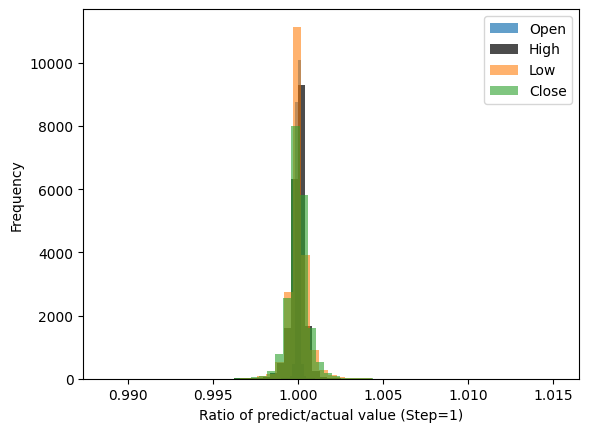

In [129]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

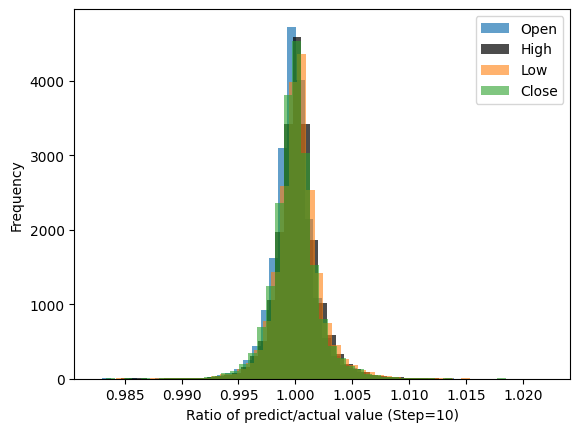

In [130]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

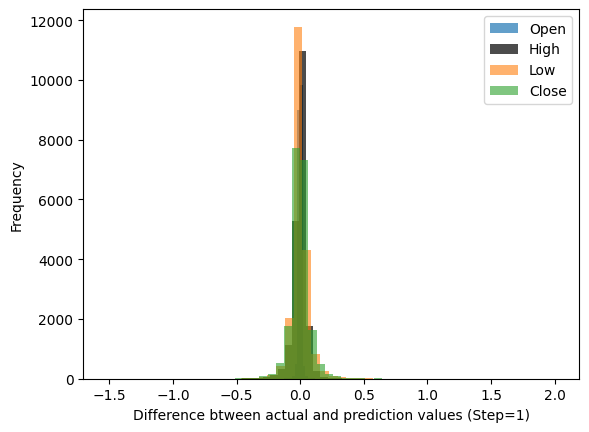

In [132]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

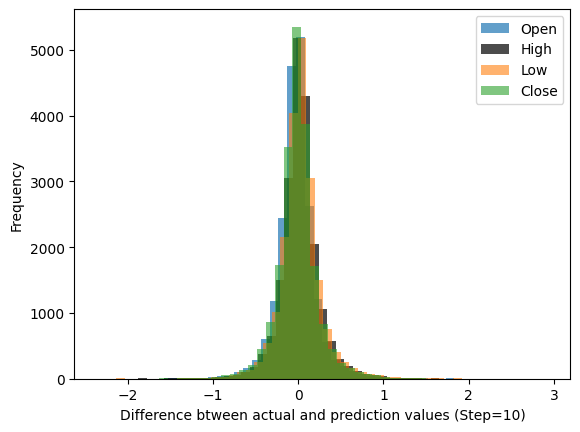

In [133]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [134]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00186 -0.00156 -0.00401 -0.00566 -0.00775 -0.00976 -0.01188
 -0.01402 -0.0162  -0.01843]
High [ 0.      -0.00229  0.00275  0.00457  0.00745  0.00995  0.01251  0.015
  0.01747  0.01991  0.02233]
Low [ 0.      -0.00089  0.0037   0.00682  0.01046  0.01392  0.01741  0.02088
  0.02432  0.02776  0.03119]
Close [ 0.      -0.00081 -0.00158 -0.00236 -0.00313 -0.00391 -0.00468 -0.00545
 -0.00622 -0.00699 -0.00777]
==============Var============
Open [0.      0.00024 0.00674 0.0132  0.01994 0.02652 0.03326 0.03995 0.04673
 0.05363 0.06035]
High [0.      0.00365 0.01006 0.01654 0.02302 0.02946 0.03611 0.04268 0.04944
 0.0563  0.06313]
Low [0.      0.00554 0.01262 0.01977 0.02656 0.03335 0.04018 0.04702 0.05394
 0.06075 0.06743]
Close [0.      0.00657 0.01287 0.01944 0.02589 0.03252 0.03909 0.04577 0.0525
 0.05911 0.06581]


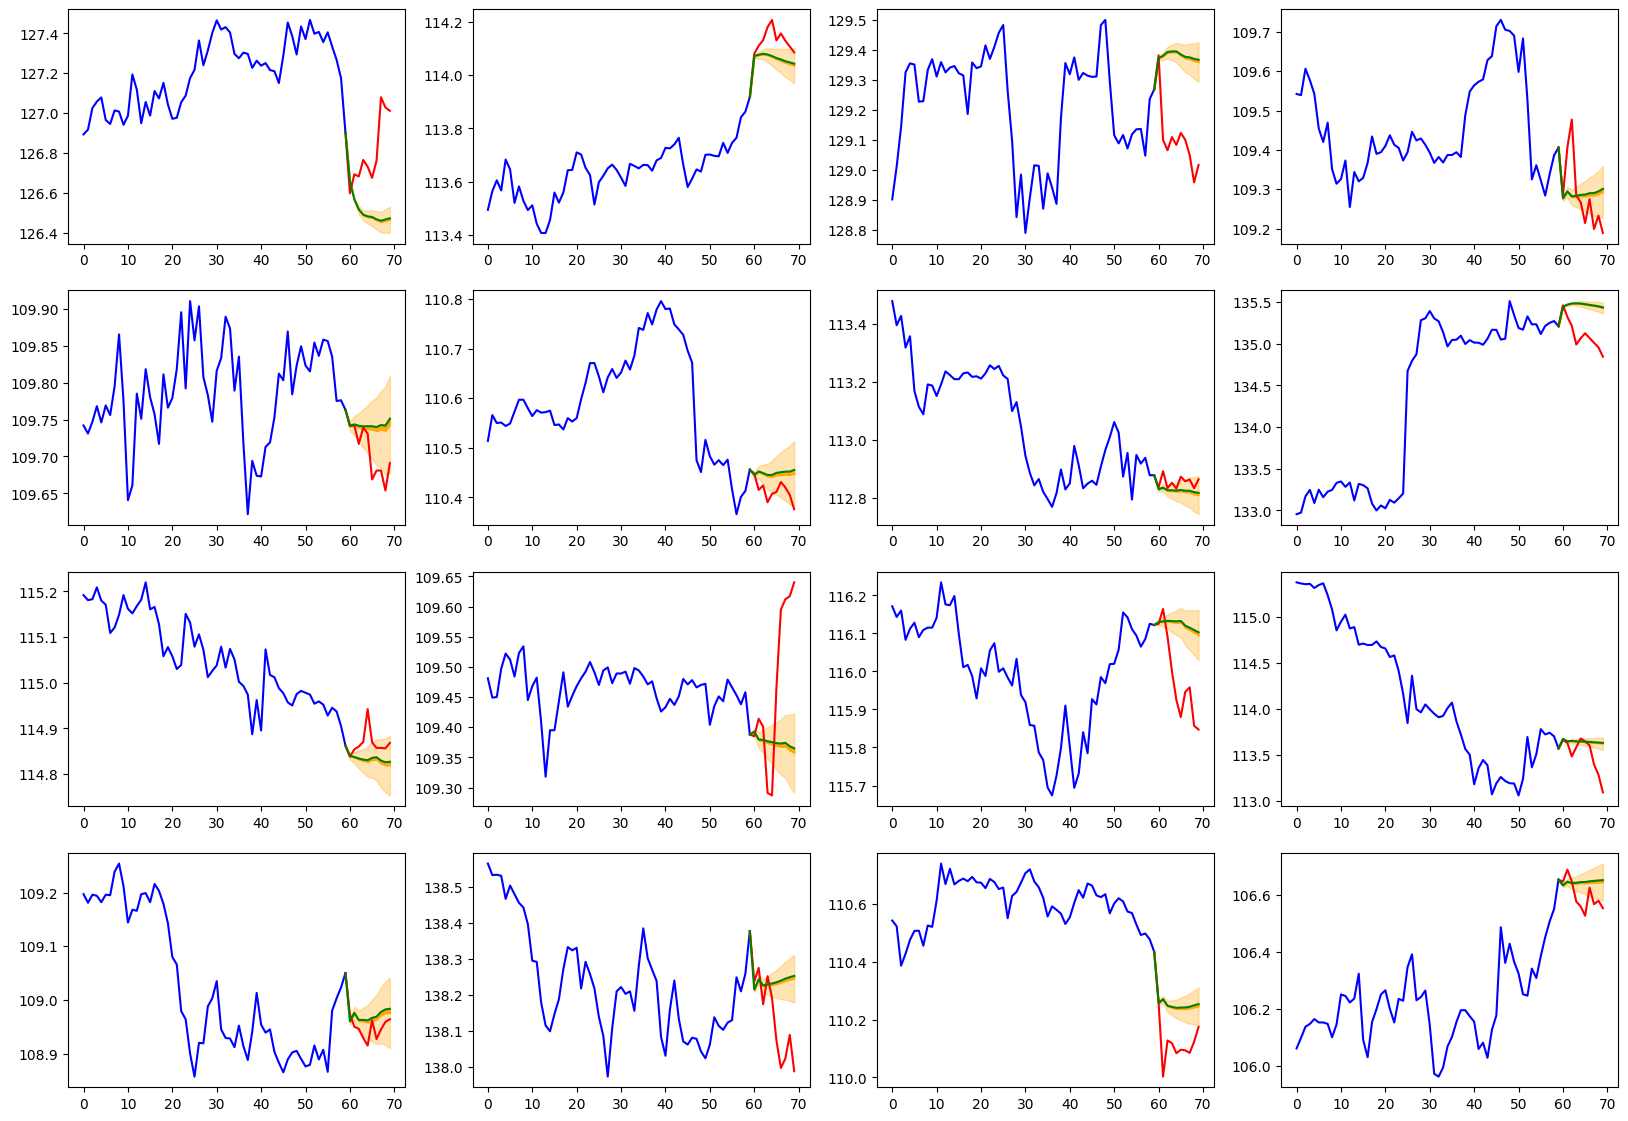

In [135]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length-1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length-1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

### Row Data (More date range)

Above result caliculated with date from 2014 to 2022. This is a bit short to learn. We can get longer data from Ducascopy, HistData etc.

In [4]:
import glob
import os

folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')
files

['L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2000.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2001.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2002.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2003.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2004.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2005.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2006.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2007.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2008.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2009.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2010.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2011.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2012.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2013.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2014.zip',
 'L:\\data\\fx\\HistData\

In [ ]:
import zipfile
import os
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [ ]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
file_path = f"{data_folder}/HistData_USDJPY_1MIN.zip"
if os.path.exists(file_path):
  df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
  file_path = f"{data_folder}/HistData_USDJPY_1MIN.csv"

  if os.path.exists(file_path):
      df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
  else:
      folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
      files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

      for file in files:
          min_df = read_histdata_file(file)
          df = pd.concat([df, min_df], axis=0)
      df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")

In [ ]:
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_30MIN.zip"

if os.path.exists(file_path):
    df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
    file_path = f"{data_folder}/HistData_USDJPY_30MIN.csv"

    if os.path.exists(file_path):
        df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
        files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

        for file in files:
            min_df = read_histdata_file(file)
            rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
            rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
            rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
            rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
            rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
            rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
            rolled_df.dropna(inplace=True)
            df = pd.concat([df, rolled_df], axis=0)
        df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")
df

 40%|████      | 4/10 [04:59<07:55, 79.25s/it]

#### Training

Same training method as Row Data is used.

#### Validation

In [ ]:
model_version = 5
print(f"loading {model_name}_v{model_version}")
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

loading finance_basic_wt_transfomer_v2


<All keys matched successfully>

[]

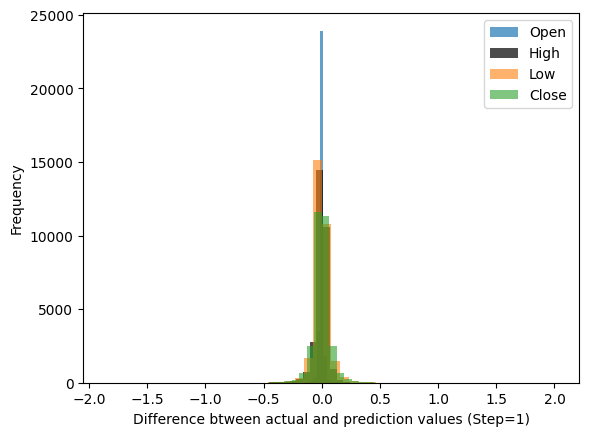

In [ ]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

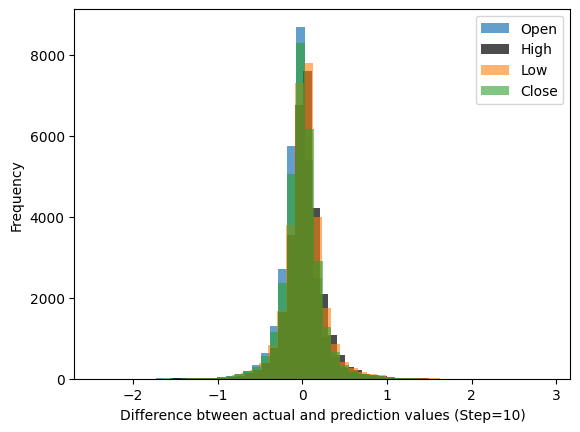

In [ ]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00285 -0.00476 -0.00969 -0.01345 -0.01727 -0.02103 -0.02474
 -0.02841 -0.03205 -0.03566]
High [ 0.      -0.0036   0.00204  0.00573  0.00971  0.01368  0.01763  0.02159
  0.02553  0.02946  0.03338]
Low [ 0.      -0.0008   0.00294  0.0061   0.00944  0.01275  0.01607  0.01939
  0.02272  0.02603  0.02934]
Close [ 0.      -0.00099 -0.00195 -0.00292 -0.00389 -0.00486 -0.00584 -0.00681
 -0.00779 -0.00877 -0.00976]
==============Var============
Open [0.      0.0004  0.00626 0.01197 0.01797 0.02377 0.0298  0.03589 0.04222
 0.04866 0.05511]
High [0.      0.00337 0.00932 0.01532 0.02123 0.02723 0.03333 0.0395  0.04584
 0.05222 0.05853]
Low [0.      0.005   0.01135 0.01764 0.02366 0.02966 0.03576 0.04198 0.0483
 0.05464 0.06084]
Close [0.      0.00593 0.01163 0.01755 0.02327 0.02918 0.0351  0.04124 0.04741
 0.05356 0.05973]


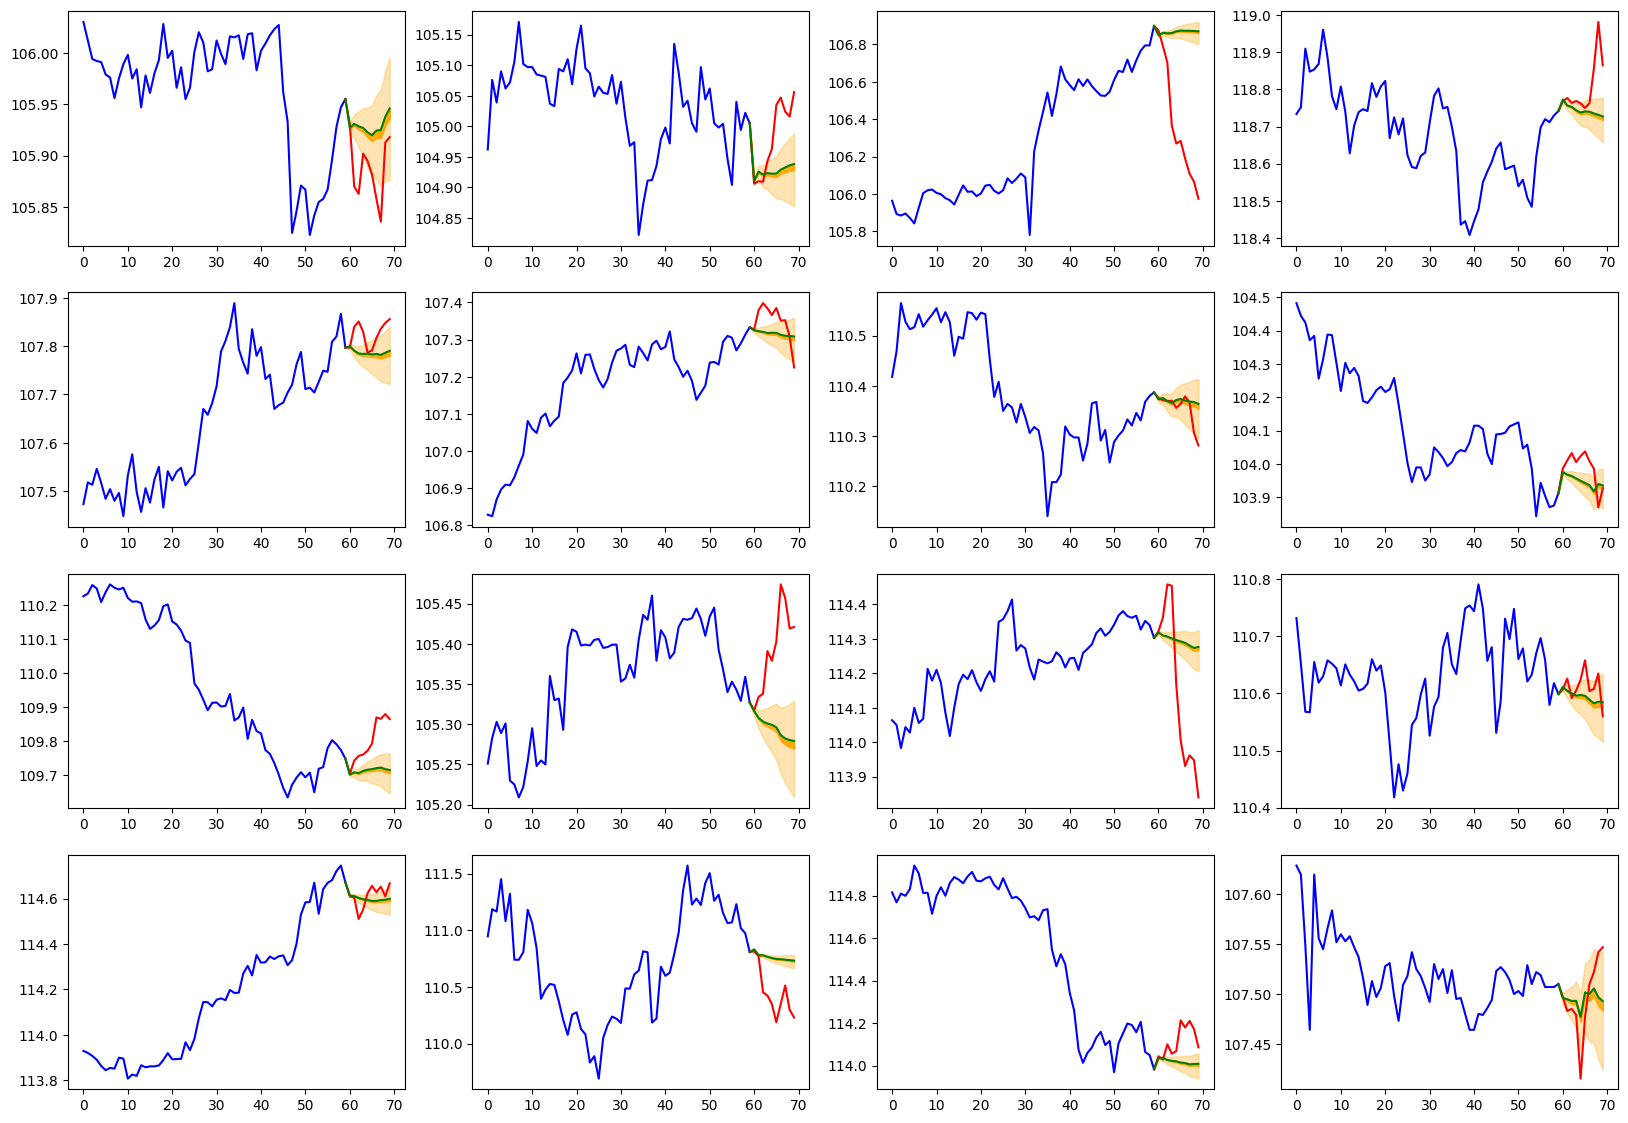

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

### Row Data with Filtering

In [38]:
import os
import pandas as pd

model_name = "finance_basic_wt_transfomer_filter"
ohlc_column = ['open','high','low','close']
file_name = "mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder, 'fx', 'OANDA-Japan MT5 Live', file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


In [39]:
target_columns = ["open","high", "low", "close"]

# create condition_df
def anomary_index(df, target_columns, alpha = 3):
    target_df = df[target_columns].diff()
    stats_df = target_df.describe()
    condition_df = pd.DataFrame()

    condition_df["upper"] = stats_df.loc["mean"] + stats_df.loc["std"] * alpha
    condition_df["lower"] = stats_df.loc["mean"] - stats_df.loc["std"] * alpha
    match_df = target_df[(target_df >= condition_df["upper"]) | (target_df <= condition_df["lower"])].dropna(how="all")
    return match_df.index

filter_index = anomary_index(df, target_columns, 3)
len(filter_index)

3954

#### Training

In [40]:
target_columns = ["open","high", "low", "close"]

# create condition_df
def common_index(df, target_columns, observation_length, prediction_length, alpha = 3):
    target_df = df[target_columns].diff()
    stats_df = target_df.describe()
    condition_df = pd.DataFrame()

    condition_df["upper"] = stats_df.loc["mean"] + stats_df.loc["std"] * alpha
    condition_df["lower"] = stats_df.loc["mean"] - stats_df.loc["std"] * alpha
    match_df = target_df[(target_df < condition_df["upper"]) & (target_df > condition_df["lower"])]
    data_length = observation_length + prediction_length
    
    valid_indices = []
    for index in range(data_length, len(match_df)):
        train_data = match_df.iloc[index - data_length:index]
        if train_data.isnull().any().any():
            continue
        valid_indices.append(index)
    return valid_indices

train_data_index = common_index(df, target_columns, 60, 10, 3)

In [44]:
diff_p = fprocess.DiffPreProcess(columns=target_columns)
time_p = fprocess.WeeklyIDProcess(freq=30, time_column= "index")
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=target_columns)
processes = [*ohlc_pre_process, standalization_p]

In [45]:
from Dataset.transformer import TimeFeatureDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, target_columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, device=device, indices=train_data_index)

In [15]:
# check outputs represent (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    break
print(src[0].shape, src[1].shape) 
print(tgt[0].shape, tgt[1].shape)

torch.Size([60, 16, 4]) torch.Size([60, 16])
torch.Size([11, 16, 4]) torch.Size([11, 16])


In [46]:
feature_size = len(target_columns)
freq = 30

# Hyper parameters
nhead = 1
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)



params = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params += p.numel()
print(f"params: {params}")

params: 2280


In [47]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)

In [48]:
model_version = 1

log_file_name = f"{model_name}_v{model_version}.csv"
logger = Logger(data_folder, model_name, log_file_name)
        
params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": target_columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ../../../Data/finance_basic_wt_transfomer_filter\finance_basic_wt_transfomer_filter_v1.csv


In [37]:
epoch = 500
best_train_loss = float('Inf')
best_valid_loss = float('Inf')
best_model = None
best_train_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_train else ''
    ))
    logger.add_training_log(loss_train, loss_valid, elapsed_time)
    
    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_model(best_train_model, f'./{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_model(best_model, model_name, model_version)
    
    if counter > patience:
        break

  0%|          | 0/555 [00:00<?, ?it/s]

100%|█████████▉| 554/555 [03:57<00:00,  2.33it/s]


[1/500] train loss: 0.0598993279, valid loss: 0.0133970069  57s] count: 0, **


100%|█████████▉| 554/555 [03:55<00:00,  2.35it/s]


[2/500] train loss: 0.0051248350, valid loss: 0.0011576039  55s] count: 0, **


100%|█████████▉| 554/555 [03:55<00:00,  2.35it/s]


[3/500] train loss: 0.0011617310, valid loss: 0.0007426414  56s] count: 0, **


100%|█████████▉| 554/555 [03:37<00:00,  2.54it/s]


[4/500] train loss: 0.0010130626, valid loss: 0.0007376946  38s] count: 0, **


100%|█████████▉| 554/555 [03:37<00:00,  2.54it/s]


[5/500] train loss: 0.0009844131, valid loss: 0.0007370014  38s] count: 0, **


100%|█████████▉| 554/555 [03:38<00:00,  2.53it/s]


[6/500] train loss: 0.0009715265, valid loss: 0.0007380184  39s] count: 0, **


100%|█████████▉| 554/555 [03:38<00:00,  2.54it/s]


[7/500] train loss: 0.0009613110, valid loss: 0.0007366878  38s] count: 0, **


100%|█████████▉| 554/555 [03:39<00:00,  2.53it/s]


[8/500] train loss: 0.0009543700, valid loss: 0.0007373399  39s] count: 0, **


100%|█████████▉| 554/555 [03:35<00:00,  2.57it/s]


[9/500] train loss: 0.0009501305, valid loss: 0.0007366739  36s] count: 0, **


100%|█████████▉| 554/555 [03:35<00:00,  2.57it/s]


[10/500] train loss: 0.0009465697, valid loss: 0.0007374135  35s] count: 0, **


100%|█████████▉| 554/555 [03:31<00:00,  2.62it/s]


[11/500] train loss: 0.0009434523, valid loss: 0.0007367192  32s] count: 0, **


100%|█████████▉| 554/555 [03:32<00:00,  2.61it/s]


[12/500] train loss: 0.0009417314, valid loss: 0.0007368637  32s] count: 0, **


100%|█████████▉| 554/555 [03:39<00:00,  2.52it/s]


[13/500] train loss: 0.0009394174, valid loss: 0.0007358667  40s] count: 0, **


100%|█████████▉| 554/555 [03:52<00:00,  2.38it/s]


[14/500] train loss: 0.0009389089, valid loss: 0.0007337808  53s] count: 0, **


100%|█████████▉| 554/555 [03:55<00:00,  2.36it/s]


[15/500] train loss: 0.0009379867, valid loss: 0.0007373621  55s] count: 0, **


100%|█████████▉| 554/555 [03:45<00:00,  2.46it/s]


[16/500] train loss: 0.0009371557, valid loss: 0.0007339969  46s] count: 0, **


100%|█████████▉| 554/555 [03:52<00:00,  2.39it/s]


[17/500] train loss: 0.0009365270, valid loss: 0.0007370778  52s] count: 0, **


100%|█████████▉| 554/555 [03:46<00:00,  2.45it/s]


[18/500] train loss: 0.0009362614, valid loss: 0.0007359587  46s] count: 0, **


100%|█████████▉| 554/555 [03:46<00:00,  2.44it/s]


[19/500] train loss: 0.0009359438, valid loss: 0.0007341800  47s] count: 0, **


100%|█████████▉| 554/555 [03:47<00:00,  2.44it/s]


[20/500] train loss: 0.0009351381, valid loss: 0.0007338593  47s] count: 0, **


100%|█████████▉| 554/555 [04:03<00:00,  2.27it/s]


[21/500] train loss: 0.0009343491, valid loss: 0.0007322578  4s] count: 0, **


100%|█████████▉| 554/555 [04:00<00:00,  2.30it/s]


[22/500] train loss: 0.0009331578, valid loss: 0.0007341437  1s] count: 0, **


100%|█████████▉| 554/555 [03:39<00:00,  2.52it/s]


[23/500] train loss: 0.0009310666, valid loss: 0.0007268585  40s] count: 0, **


100%|█████████▉| 554/555 [03:59<00:00,  2.32it/s]


[24/500] train loss: 0.0009279547, valid loss: 0.0007237976  59s] count: 0, **


100%|█████████▉| 554/555 [04:21<00:00,  2.12it/s]


[25/500] train loss: 0.0009204756, valid loss: 0.0007176099  22s] count: 0, **


100%|█████████▉| 554/555 [04:08<00:00,  2.23it/s]


[26/500] train loss: 0.0009116796, valid loss: 0.0007129610  8s] count: 0, **


100%|█████████▉| 554/555 [04:11<00:00,  2.20it/s]


[27/500] train loss: 0.0009075633, valid loss: 0.0007120452  12s] count: 0, **


100%|█████████▉| 554/555 [04:01<00:00,  2.29it/s]


[28/500] train loss: 0.0009047319, valid loss: 0.0007055924  2s] count: 0, **


100%|█████████▉| 554/555 [03:52<00:00,  2.39it/s]


[29/500] train loss: 0.0008993061, valid loss: 0.0007016497  52s] count: 0, **


100%|█████████▉| 554/555 [04:21<00:00,  2.12it/s]


[30/500] train loss: 0.0008923575, valid loss: 0.0006939380  22s] count: 0, **


100%|█████████▉| 554/555 [04:03<00:00,  2.28it/s]


[31/500] train loss: 0.0008827345, valid loss: 0.0006955760  3s] count: 0, **


100%|█████████▉| 554/555 [03:47<00:00,  2.44it/s]


[32/500] train loss: 0.0008787181, valid loss: 0.0006817445  47s] count: 0, **


100%|█████████▉| 554/555 [03:55<00:00,  2.35it/s]


[33/500] train loss: 0.0008780390, valid loss: 0.0006724066  56s] count: 0, **


100%|█████████▉| 554/555 [03:35<00:00,  2.57it/s]


[34/500] train loss: 0.0008650846, valid loss: 0.0006641706  35s] count: 0, **


100%|█████████▉| 554/555 [03:17<00:00,  2.81it/s]


[35/500] train loss: 0.0008565938, valid loss: 0.0006638423  17s] count: 0, **


100%|█████████▉| 554/555 [03:17<00:00,  2.80it/s]


[36/500] train loss: 0.0008504997, valid loss: 0.0006477715  18s] count: 0, **


100%|█████████▉| 554/555 [03:14<00:00,  2.85it/s]


[37/500] train loss: 0.0008473714, valid loss: 0.0006405662  14s] count: 0, **


100%|█████████▉| 554/555 [03:15<00:00,  2.84it/s]


[38/500] train loss: 0.0008351978, valid loss: 0.0006323944  15s] count: 0, **


100%|█████████▉| 554/555 [03:14<00:00,  2.85it/s]


[39/500] train loss: 0.0008286867, valid loss: 0.0006236929  14s] count: 0, **


100%|█████████▉| 554/555 [03:13<00:00,  2.86it/s]


[40/500] train loss: 0.0008300790, valid loss: 0.0006216184  14s] count: 0, **


100%|█████████▉| 554/555 [03:22<00:00,  2.74it/s]


[41/500] train loss: 0.0008189378, valid loss: 0.0006130157  22s] count: 1, **


100%|█████████▉| 554/555 [03:18<00:00,  2.79it/s]


[42/500] train loss: 0.0008152808, valid loss: 0.0006063588  19s] count: 0, **


100%|█████████▉| 554/555 [03:17<00:00,  2.81it/s]


[43/500] train loss: 0.0008128502, valid loss: 0.0006056200  17s] count: 0, **


100%|█████████▉| 554/555 [03:18<00:00,  2.79it/s]


[44/500] train loss: 0.0008152479, valid loss: 0.0006050002  19s] count: 0, **


100%|█████████▉| 554/555 [03:18<00:00,  2.79it/s]


[45/500] train loss: 0.0008057119, valid loss: 0.0005965609  19s] count: 1, **


100%|█████████▉| 554/555 [03:25<00:00,  2.69it/s]


[46/500] train loss: 0.0008041829, valid loss: 0.0005963939  26s] count: 0, **


100%|█████████▉| 554/555 [03:27<00:00,  2.68it/s]


[47/500] train loss: 0.0008021629, valid loss: 0.0005957586  27s] count: 0, **


100%|█████████▉| 554/555 [03:25<00:00,  2.70it/s]


[48/500] train loss: 0.0008033736, valid loss: 0.0005919015  25s] count: 0, **


100%|█████████▉| 554/555 [03:43<00:00,  2.48it/s]


[49/500] train loss: 0.0007987718, valid loss: 0.0005888692  44s] count: 1, **


100%|█████████▉| 554/555 [03:56<00:00,  2.35it/s]


[50/500] train loss: 0.0007969713, valid loss: 0.0005912477  56s] count: 0, **


100%|█████████▉| 554/555 [03:40<00:00,  2.51it/s]


[51/500] train loss: 0.0007967255, valid loss: 0.0005855244  41s] count: 0, **


100%|█████████▉| 554/555 [03:57<00:00,  2.34it/s]


[52/500] train loss: 0.0007981499, valid loss: 0.0005814859  57s] count: 0, **


100%|█████████▉| 554/555 [03:54<00:00,  2.37it/s]


[53/500] train loss: 0.0007940775, valid loss: 0.0005837735  54s] count: 1, **


100%|█████████▉| 554/555 [03:50<00:00,  2.40it/s]


[54/500] train loss: 0.0007909898, valid loss: 0.0005789176  51s] count: 0, **


100%|█████████▉| 554/555 [03:38<00:00,  2.53it/s]


[55/500] train loss: 0.0007888219, valid loss: 0.0005811966  39s] count: 0, **


100%|█████████▉| 554/555 [03:49<00:00,  2.41it/s]


[56/500] train loss: 0.0007933054, valid loss: 0.0005792807  50s] count: 0, **


100%|█████████▉| 554/555 [03:44<00:00,  2.47it/s]


[57/500] train loss: 0.0007887201, valid loss: 0.0005770389  45s] count: 1, **


100%|█████████▉| 554/555 [03:47<00:00,  2.44it/s]


[58/500] train loss: 0.0007852837, valid loss: 0.0005767516  47s] count: 0, **


100%|█████████▉| 554/555 [03:36<00:00,  2.56it/s]


[59/500] train loss: 0.0007874375, valid loss: 0.0005731173  36s] count: 0, **


100%|█████████▉| 554/555 [03:39<00:00,  2.53it/s]


[60/500] train loss: 0.0007818863, valid loss: 0.0005727953  39s] count: 1, **


100%|█████████▉| 554/555 [03:44<00:00,  2.47it/s]


[61/500] train loss: 0.0007870929, valid loss: 0.0005714060  45s] count: 0, **


100%|█████████▉| 554/555 [03:50<00:00,  2.41it/s]


[62/500] train loss: 0.0007847961, valid loss: 0.0005726594  50s] count: 1, **


100%|█████████▉| 554/555 [03:50<00:00,  2.40it/s]


[63/500] train loss: 0.0007812556, valid loss: 0.0005687167  51s] count: 2, **


100%|█████████▉| 554/555 [03:40<00:00,  2.51it/s]


[64/500] train loss: 0.0007855145, valid loss: 0.0005711015  41s] count: 0, **


100%|█████████▉| 554/555 [03:49<00:00,  2.42it/s]


[65/500] train loss: 0.0007821706, valid loss: 0.0005715737  49s] count: 1, **


100%|█████████▉| 554/555 [03:44<00:00,  2.46it/s]


[66/500] train loss: 0.0007775131, valid loss: 0.0005700331  45s] count: 2, **


100%|█████████▉| 554/555 [03:58<00:00,  2.32it/s]


[67/500] train loss: 0.0007817053, valid loss: 0.0005685656  59s] count: 0, **


100%|█████████▉| 554/555 [03:46<00:00,  2.44it/s]


[68/500] train loss: 0.0007741476, valid loss: 0.0005658333  47s] count: 1, **


100%|█████████▉| 554/555 [03:50<00:00,  2.40it/s]


[69/500] train loss: 0.0007819660, valid loss: 0.0005647529  51s] count: 0, **


100%|█████████▉| 554/555 [03:48<00:00,  2.42it/s]


[70/500] train loss: 0.0007762635, valid loss: 0.0005672492  49s] count: 1, **


100%|█████████▉| 554/555 [03:42<00:00,  2.49it/s]


[71/500] train loss: 0.0007760563, valid loss: 0.0005625296  42s] count: 2, **


100%|█████████▉| 554/555 [03:47<00:00,  2.44it/s]


[72/500] train loss: 0.0007783586, valid loss: 0.0005660857  47s] count: 3, **


100%|█████████▉| 554/555 [03:49<00:00,  2.41it/s]


[73/500] train loss: 0.0007769648, valid loss: 0.0005659409  50s] count: 4, **


100%|█████████▉| 554/555 [03:56<00:00,  2.34it/s]


[74/500] train loss: 0.0007756674, valid loss: 0.0005643402  57s] count: 5, **


100%|█████████▉| 554/555 [04:10<00:00,  2.21it/s]


[75/500] train loss: 0.0007776207, valid loss: 0.0005664466  11s] count: 6, **


#### Validation

In [19]:
model_version = 1
print(f"loading {model_name}_v{model_version}")
model.load_state_dict(torch.load(f'{data_folder}/{model_name}/{model_name}_v{model_version}.torch'))

loading finance_basic_wt_transfomer_filter_v1


<All keys matched successfully>

In [142]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [21]:
pred_sample = prediction(src, tgt[1])
pred_sample[:, 0, :]

tensor([[0.2426, 0.0485, 0.3252, 0.2593],
        [0.2534, 0.0488, 0.3191, 0.2274],
        [0.2217, 0.0374, 0.3214, 0.2306],
        [0.2405, 0.0448, 0.3200, 0.2286],
        [0.2383, 0.0441, 0.3202, 0.2288],
        [0.2446, 0.0456, 0.3197, 0.2283],
        [0.2275, 0.0394, 0.3210, 0.2300],
        [0.2174, 0.0346, 0.3218, 0.2312],
        [0.2321, 0.0404, 0.3207, 0.2296],
        [0.2241, 0.0381, 0.3213, 0.2304],
        [0.2304, 0.0407, 0.3208, 0.2297]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [23]:
from Dataset import revert_process

src_values = src[0].cpu().detach().numpy()
r_data = revert_process.revert(ds, src_values, [index for index in range(0, 16)], is_tgt=False)
r_data[:, 0, :]

array([[109.03039585, 109.04499989, 108.92600002, 108.94459278],
       [108.9428033 , 108.98600001, 108.88800009, 108.98421784],
       [108.98117841, 108.98299996, 108.89899994, 108.9678284 ],
       [108.96356802, 109.01599998, 108.90999978, 108.93143385],
       [108.92596253, 109.00200005, 108.92199958, 108.99006376],
       [108.98133318, 109.0530001 , 108.97699937, 109.04969394],
       [109.04170272, 109.08299999, 108.9509994 , 109.01129908],
       [109.00109812, 109.039     , 108.89199946, 108.91188839],
       [108.9015087 , 108.98499999, 108.90399927, 108.96751749],
       [108.9558798 , 108.97700007, 108.89299913, 108.9651318 ],
       [108.95226561, 109.00000007, 108.9379993 , 108.98475175],
       [108.97064585, 109.0350001 , 108.96799923, 109.01037307],
       [108.99502453, 109.07099999, 108.98699917, 109.04099572],
       [109.02440187, 109.12800006, 109.02899905, 109.11462941],
       [109.09676828, 109.24699998, 109.10399889, 109.23527519],
       [109.21612265, 109

In [24]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans[0].cpu().detach().numpy()
    
    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

[]

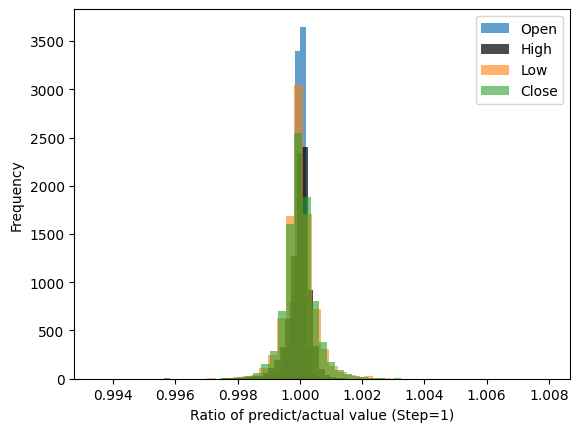

In [28]:
import matplotlib.pyplot as plt

step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

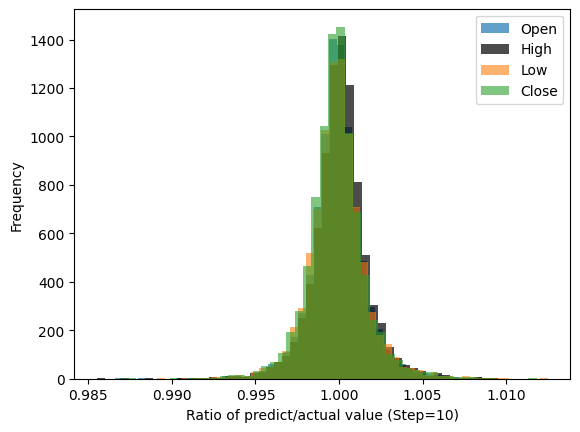

In [29]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

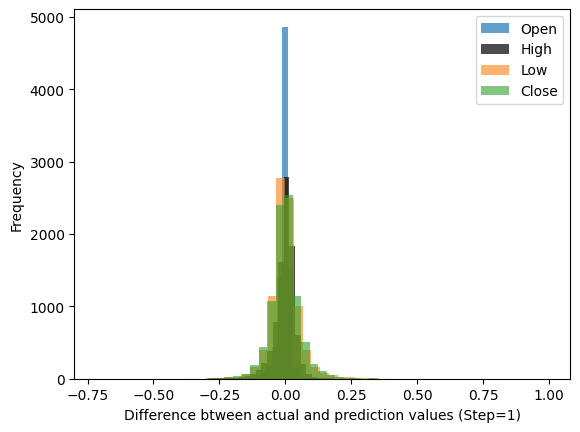

In [30]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

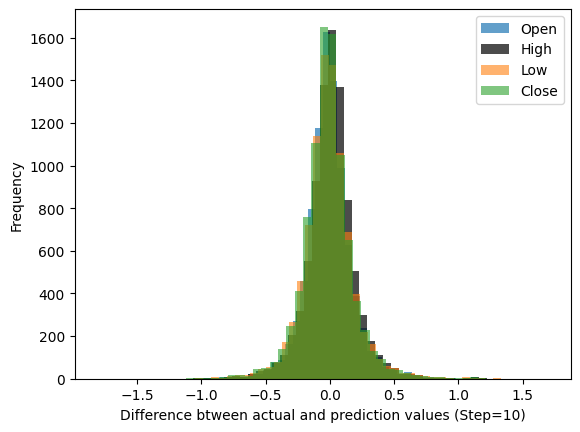

In [31]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [32]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.0046  -0.00294 -0.00424 -0.00435 -0.00501 -0.00543 -0.00607
 -0.00656 -0.00693 -0.0072 ]
High [ 0.      -0.00262 -0.00033  0.00051  0.002    0.00323  0.0045   0.00572
  0.00704  0.00844  0.00998]
Low [ 0.      -0.00057 -0.0019  -0.00278 -0.00393 -0.00498 -0.00612 -0.00729
 -0.00833 -0.00947 -0.01048]
Close [ 0.      -0.0011  -0.00304 -0.00474 -0.00663 -0.00844 -0.01044 -0.01235
 -0.01417 -0.01595 -0.01768]
==============Var============
Open [0.      0.00093 0.00462 0.00799 0.01167 0.0154  0.01929 0.02336 0.02752
 0.03171 0.03604]
High [0.      0.00204 0.00581 0.00952 0.01325 0.01711 0.02125 0.02534 0.02949
 0.03376 0.03801]
Low [0.      0.00365 0.00769 0.01172 0.01559 0.01955 0.02357 0.02775 0.03204
 0.03632 0.04078]
Close [0.      0.00372 0.00742 0.01115 0.01491 0.01879 0.02285 0.02697 0.03118
 0.03546 0.03996]


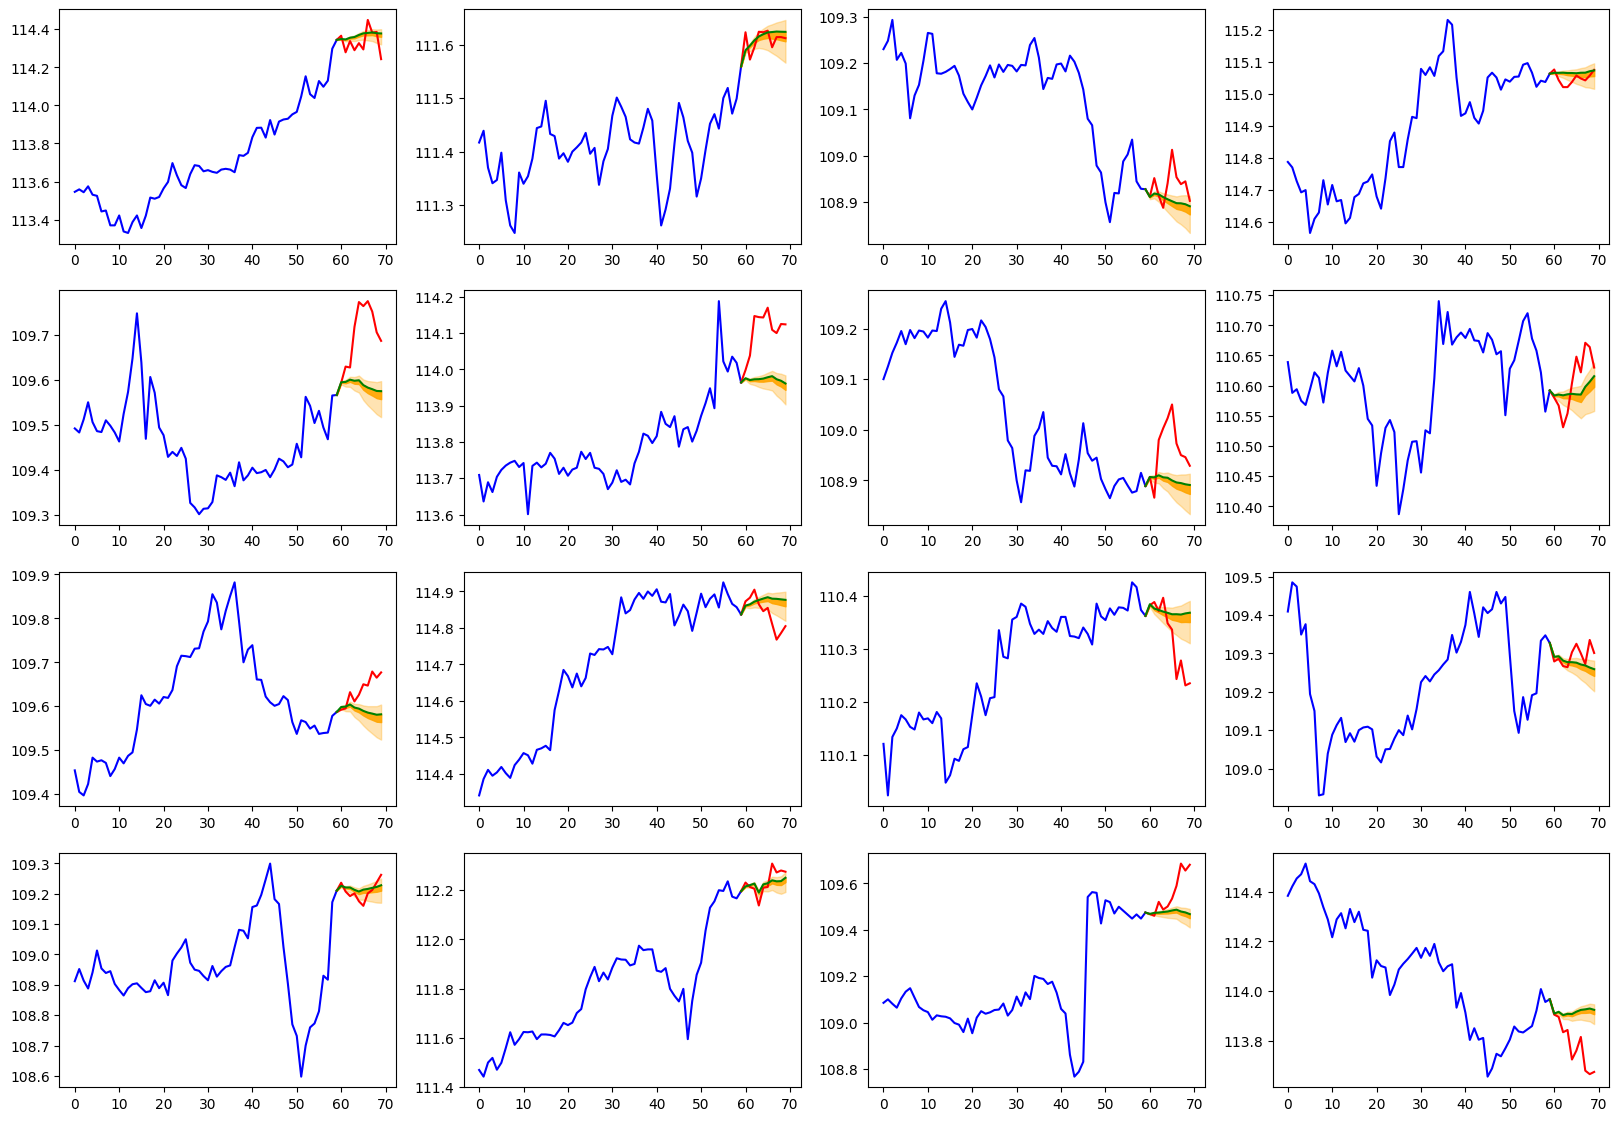

In [33]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)


for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length-1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length-1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

##### Compare with no filtering

Check whether the model predicts values more accurately than no filtering version or just filtered values are small

In [137]:
model_name = "finance_basic_wt_transfomer"
model_version = 1

model.load_state_dict(torch.load(f'{data_folder}/{model_name}/{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [143]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans[0].cpu().detach().numpy()
    
    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

[]

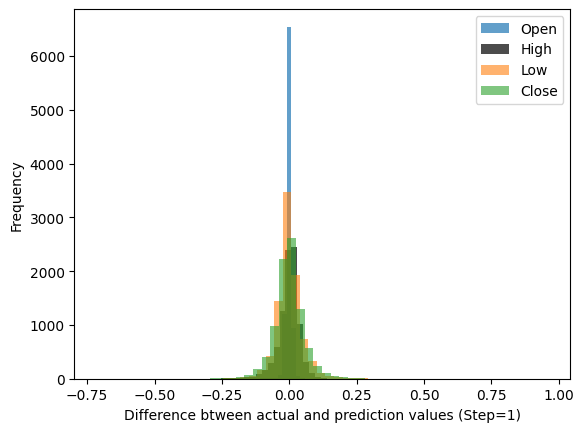

In [144]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

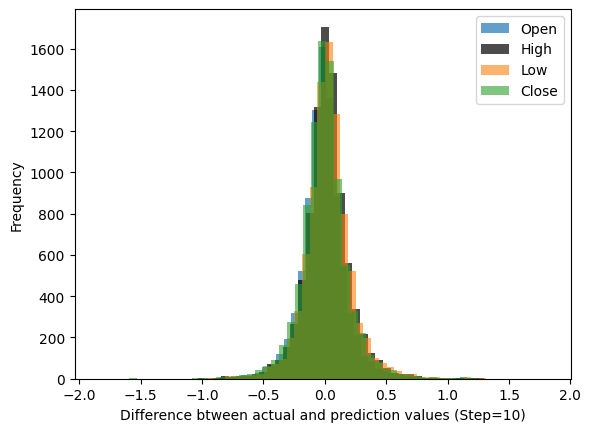

In [145]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [146]:
# accuracy for filtered values are almost same for both models


np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00173 -0.0017  -0.00364 -0.00497 -0.0067  -0.00827 -0.0101
 -0.01186 -0.01355 -0.0152 ]
High [ 0.      -0.00176  0.00225  0.00368  0.00602  0.00797  0.00996  0.01185
  0.0138   0.01583  0.01795]
Low [0.      0.0003  0.00461 0.00779 0.01132 0.01473 0.0181  0.02142 0.02487
 0.02823 0.03171]
Close [ 0.      -0.00047 -0.00079 -0.00124 -0.0017  -0.00214 -0.00275 -0.00328
 -0.00371 -0.0041  -0.00442]
==============Var============
Open [0.      0.00015 0.00379 0.00759 0.01138 0.01517 0.0191  0.02324 0.02738
 0.03165 0.03593]
High [0.      0.00197 0.00567 0.00944 0.01316 0.01702 0.02119 0.02531 0.02954
 0.03393 0.0383 ]
Low [0.      0.00297 0.00708 0.0111  0.01504 0.01906 0.02318 0.02736 0.03172
 0.03596 0.04036]
Close [0.      0.00369 0.00739 0.0111  0.01484 0.01872 0.02277 0.02688 0.03108
 0.03533 0.03984]


### Summary

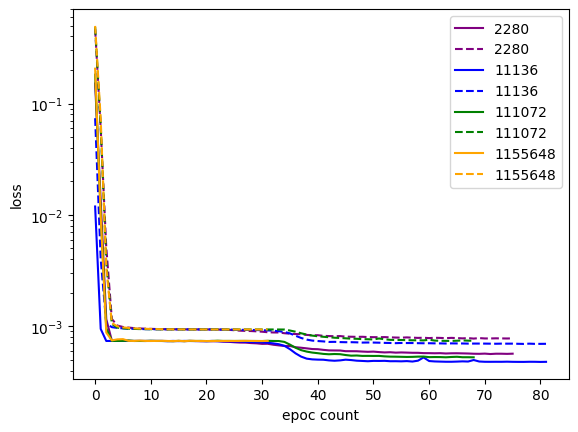

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob

model_name = "finance_basic_wt_transfomer_filter"
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")
colors = ['Purple', 'Blue', 'Green', 'Orange', 'Red',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn', 'Grey']

eval_loss_row = []
eval_params_row = []

for index, log_file in enumerate(logs_files):
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["time", "train_loss", "eval_loss"]
    eval_params_row.append(params_num)
    eval_loss_row.append(logs.eval_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[index])
    plt.plot([*logs.index], logs.train_loss, label=params_num, linestyle="--", color=colors[index])
plt.xlabel("epoc count")
plt.ylabel("loss")
plt.legend()
plt.show()

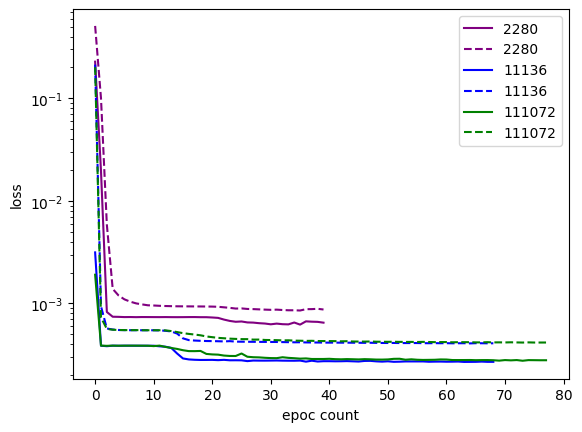

In [70]:
model_name = "finance_basic_wt_transfomer_filter_ext"
logs_files = glob.glob(f"{data_folder}/{model_name}/{model_name}*_params.json")

eval_loss_ext = []
eval_params_ext = []

for index, log_file in enumerate(logs_files):
    with open(log_file) as fp:
        params = json.load(fp)
    params_num = params["params_num"]
    log_file = log_file.replace("_params.json", ".csv")
    logs = pd.read_csv(log_file, header=None)
    logs.columns = ["time", "train_loss", "eval_loss"]
    eval_params_ext.append(params_num)
    eval_loss_ext.append(logs.eval_loss.min())
    plt.yscale("log")
    plt.plot([*logs.index], logs.eval_loss, label=params_num, color=colors[index])
    plt.plot([*logs.index], logs.train_loss, label=params_num, linestyle="--", color=colors[index])
plt.xlabel("epoc count")
plt.ylabel("loss")
plt.legend()
plt.show()

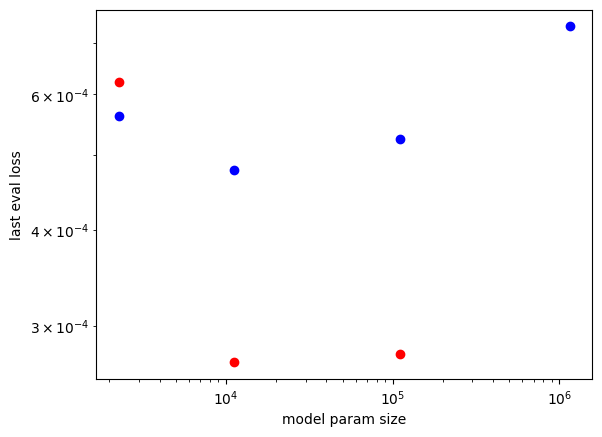

In [76]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("model param size")
plt.ylabel("last eval loss")
plt.plot(eval_params_row, eval_loss_row, 'o', color='blue')
plt.plot(eval_params_ext, eval_loss_ext, 'o', color='red')
plt.show()

### Argumented Data with Shift Rolling

We have 2 possible reason that expect why validation loss stopped improvement

1. data volume is less
2. data feature is less

I suspect data feature is less. To confirm that, increase the data volume by rolling 1min data to 30min data with shifting the time.

2 will be confirmed by appling linear or conv1d layer to input (ref another notebook)

In [82]:
import zipfile
import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_format='%Y%m%d %H%M%S', index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [83]:
import glob
import os

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"

folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

for file in files:
    min_df = read_histdata_file(file)
    df = pd.concat([df, min_df], axis=0)

In [84]:
freq = 30
freq_str = "30MIN"

org_df = df.groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()

DFS = []
BIAS = 2

for bias in range(-BIAS, BIAS+1):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    #rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum()
    #rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close], axis=1)
    rolled_df = rolled_df[rolled_df.index.isin(org_df.index)]
    DFS.append(rolled_df)

In [85]:
from Dataset.transformer import TimeFeatureDataset

ds_array = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for df_ in DFS:
  ohlc_column = ['open','high','low','close']
  #volume_column = ["tick_volume"]
  #columns = ohlc_column+volume_column
  columns = ohlc_column

  #log_p = fprocess.LogPreProcess(columns=ohlc_column)
  diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
  time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
  #ohlc_pre_process = [log_p, diff_p, time_p]
  ohlc_pre_process = [diff_p, time_p]

  standalization_p = fprocess.MinMaxPreProcess(columns=columns)
  processes = [*ohlc_pre_process, standalization_p]

  #Dataset parameters
  batch_size = 64
  observation_length = 60
  prediction_length = 10

  ds = TimeFeatureDataset(df_, columns, time_column="index",
                          processes=processes, observation_length=observation_length,
                          prediction_length=prediction_length, device=device)
  ds_array.append(ds)

#### Training

In [86]:
def train(model, ds_array, optimizer, criterion, batch_size, device):
    
    model.train()
    losses = 0
    length = 0
    end_index = 0
    
    mini_batch = int(batch_size/len(ds_array))
    if mini_batch <= 1:
        mini_batch = 2
        
    ds_length = []
    for ds in ds_array:
        ds.train()
        ds_length.append(len(ds))
    
    end_index = min(ds_length)
    
    end = False
    for index in tqdm(range(0, end_index - mini_batch, mini_batch)):
        length+=1.0
        sources = []
        sources_time = []
        targets = []
        targets_time = []
        for ds in ds_array:
            try:
                src, tgt = ds[index:index+mini_batch]
                sources.append(src[0])
                sources_time.append(src[1])
                targets.append(tgt[0])
                targets_time.append(tgt[1])
            except:
                end = True
                break
        if end:
            break
        src = torch.concat(sources, dim=1)
        src_time = torch.concat(sources_time, dim=1)
        tgt = torch.concat(targets, dim=1)
        tgt_time = torch.concat(targets_time, dim=1)
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [87]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

In [88]:
feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.01


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


params = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params += p.numel()

In [89]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [92]:
import json
import logging

model_name = f"finance_basic_wt_transfomer_shift{BIAS}"
model_version = "1"

log_file_path = "{model_name}_{model_version}.csv"
logger = Logger(data_folder, model_name, log_file_path)

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

logger.save_params(params, model_name, model_version)
print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ../../../Data/finance_basic_wt_transfomer_shift2\{model_name}_{model_version}.csv


In [95]:
epoch = 500
best_train_loss = float('Inf')
best_valid_loss = float('Inf')
best_model = None
best_train_model = None
patience = 3
counter = 0

ACTUAL_DS_INDEX = BIAS

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds_array=ds_array, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds_array[ACTUAL_DS_INDEX], criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_valid else ''
    )
    print(log)
    logger.add_training_log(loss_train, loss_valid)
    
    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_model(best_train_model, f'./{model_name}_train', model_version)
        scheduler.step()
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_model(best_model, model_name, model_version)
    
    if counter > patience:
        break

100%|██████████| 4585/4585 [58:44<00:00,  1.30it/s] 


[1/500] train loss: 0.0006397066, valid loss: 0.0004781739  47s] count: 0, **


100%|██████████| 4585/4585 [1:00:59<00:00,  1.25it/s]


[2/500] train loss: 0.0006374280, valid loss: 0.0004722674  1s] count: 0, **


100%|██████████| 4585/4585 [59:01<00:00,  1.29it/s] 


[3/500] train loss: 0.0006343471, valid loss: 0.0004694718  3s] count: 0, **


100%|██████████| 4585/4585 [1:00:20<00:00,  1.27it/s]


[4/500] train loss: 0.0006264661, valid loss: 0.0004686276  22s] count: 0, **


100%|██████████| 4585/4585 [1:00:06<00:00,  1.27it/s]


[5/500] train loss: 0.0006245103, valid loss: 0.0004719404  8s] count: 0, 


100%|██████████| 4585/4585 [59:56<00:00,  1.27it/s] 


[6/500] train loss: 0.0006201566, valid loss: 0.0004711307  58s] count: 0, 


100%|██████████| 4585/4585 [1:00:06<00:00,  1.27it/s]


[7/500] train loss: 0.0006220293, valid loss: 0.0004637009  8s] count: 0, **


100%|██████████| 4585/4585 [1:00:43<00:00,  1.26it/s]


[8/500] train loss: 0.0006130252, valid loss: 0.0004657453  44s] count: 1, 


 17%|█▋        | 760/4585 [11:41<58:52,  1.08it/s]  


[9/500] train loss: 0.0006056204, valid loss: 0.0004704219  43s] count: 0, 


100%|██████████| 4585/4585 [1:05:47<00:00,  1.16it/s]


[10/500] train loss: 0.0006107292, valid loss: 0.0004653349  49s] count: 0, 


100%|██████████| 4585/4585 [59:53<00:00,  1.28it/s]  


[11/500] train loss: 0.0006134011, valid loss: 0.0004618430  55s] count: 1, **


100%|██████████| 4585/4585 [57:53<00:00,  1.32it/s] 


[12/500] train loss: 0.0006080195, valid loss: 0.0004650265  55s] count: 2, 


100%|██████████| 4585/4585 [55:45<00:00,  1.37it/s]


[13/500] train loss: 0.0006084723, valid loss: 0.0004658834  46s] count: 3, 


#### Validation

As validation loss is too high, skip the confirmation for now

### Argumented Data with Using Another Symbols

Note implemented yet.
Convert each symbol data to indicate almost same features. For example, applying diff then divide by minimum point of each symbol.

In [ ]:
import glob
import os

folder_path = os.path.abspath('L:/data/fx/Dukascopy')
# folders = glob.glob(folder_path + '/*JPY')
folders = [folder_path + '/USDJPY', folder_path + '/AUDJPY', folder_path + '/CHFJPY', folder_path + '/EURJPY']

In [ ]:
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame()
ohlc_column = ['Open', 'High', 'Low', 'Close']
volume_column = "Volume"
DFS = []

for folder in folders:
    files = glob.glob(folder + '/*.csv')
    for file in tqdm(files):
        min_df = pd.read_csv(file, index_col=0, parse_dates=True)
        rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
        rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
        rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
        rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
        rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
        rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
        rolled_df.dropna(inplace=True)
        df = pd.concat([df, rolled_df], axis=0)
        DFS.append(df)

### Argumented Data with Applying All Ideas

Not implemented yet

### Add Features: volume and spread

In [ ]:
import os
import pandas as pd


ohlc_column = ['open','high','low','close']
additional_columns = ["tick_volume", "spread"]
file_path = os.path.abspath('../../Data/mt5_USDJPY_min30.csv')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

#### Define Model
Same as Baseline with weekly position

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [ ]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_time = self.positional_encoding(src_time)
        src = torch.add(src, src_time)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = torch.add(tgt, tgt_time)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [ ]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

#### Training

In [ ]:
columns = ohlc_column+additional_columns

#log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset parameters
batch_size = 64
observation_length = 30
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length)

In [ ]:
# # check outputs represent (data_length, chunk_size, feature_size)
# ds.train()
# for index in range(0, len(ds)-16, 16):
#     src, tgt = ds[index: index+16]
#     break
# print(src[0].shape, src[1].shape) 
# print(tgt[0].shape, tgt[1].shape)

In [ ]:
feature_size = 6
freq=30

# Hyper parameters
nhead = 2
dim_feedforward = 5000
num_encoder_layers = 12
num_decoder_layers = 12
dropout = 0.001


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [ ]:
lr = 0.0005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

model_name = f"finance_basic_wt_transfomer_nodiff_d0001"
model_version = "1"

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print("number of parameters: ", params)

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

number of parameters:  1568928
saved params on  ../../Data//finance_basic_wt_transfomer_nodiff_d0001_1_params.json
training log will be saved on  ../../Data//finance_basic_wt_transfomer_nodiff_d0001_1.log


In [ ]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    logging.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    print(log)
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 1101/1102 [11:33<00:00,  1.59it/s]


[1/500] train loss: 0.0578787685, valid loss: 0.0037063293  34s] count: 0, **


100%|█████████▉| 1101/1102 [09:49<00:00,  1.87it/s]


[2/500] train loss: 0.0021434757, valid loss: 0.0033608952  50s] count: 0, **


100%|█████████▉| 1101/1102 [09:44<00:00,  1.88it/s]


[3/500] train loss: 0.0020198564, valid loss: 0.0035293275  45s] count: 0, 


100%|█████████▉| 1101/1102 [09:45<00:00,  1.88it/s]


[4/500] train loss: 0.0019943540, valid loss: 0.0034053557  45s] count: 1, 


100%|█████████▉| 1101/1102 [09:48<00:00,  1.87it/s]


[5/500] train loss: 0.0020010936, valid loss: 0.0034459734  48s] count: 2, 


100%|█████████▉| 1101/1102 [09:44<00:00,  1.88it/s]


[6/500] train loss: 0.0019794028, valid loss: 0.0032379963  45s] count: 3, **


100%|█████████▉| 1101/1102 [09:41<00:00,  1.89it/s]


[7/500] train loss: 0.0019621129, valid loss: 0.0033722063  41s] count: 0, 


100%|█████████▉| 1101/1102 [09:50<00:00,  1.87it/s]


[8/500] train loss: 0.0019592808, valid loss: 0.0034250473  50s] count: 1, 


100%|█████████▉| 1101/1102 [09:43<00:00,  1.89it/s]


[9/500] train loss: 0.0019450955, valid loss: 0.0033467188  43s] count: 2, 


100%|█████████▉| 1101/1102 [09:44<00:00,  1.88it/s]


[10/500] train loss: 0.0019434208, valid loss: 0.0034109939  44s] count: 3, 


### Add Features: Another Symbols

Not implemented yet

In [4]:
folder_path = os.path.abspath('L:/data/fx/HistData')

In [5]:
import zipfile
import os

import pandas as pd

ohlc_columns = ['open', 'high', 'low', 'close', 'volume']

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ohlc_columns
    df.index.name = "time"
    return df

In [6]:
import glob
import os

import pandas as pd
from tqdm import tqdm


folder_path = os.path.abspath('L:/data/fx/HistData')
symbols = ['USDJPY', 'EURJPY', 'AUDJPY', 'GBPJPY', 'CHFJPY', 'EURUSD', 'AUDUSD', 'GBPUSD', 'USDCHF']

In [ ]:

DFS = {}

for symbol in symbols:
    folder_path = os.path.abspath(f'L:/data/fx/HistData/{symbol}')
    files = glob.glob(folder_path + f'/DAT_ASCII_{symbol}_M1_*.zip')
    df = pd.DataFrame()
    
    for file in files:
        min_df = read_histdata_file(file)
        df = pd.concat([df, min_df], axis=0)
    DFS[symbol] = df

In [74]:
for key ,df in DFS.items():
    df.to_csv(f'L:/data/fx/HistData_{key}_1MIN.csv')

In [5]:
min_df = pd.read_csv(f'L:/data/fx/HistData_USDJPY_1MIN.csv', index_col=0, parse_dates=True)
min_df

,open,high,low,close,volume
time,,,,,
2000-05-30 17:58:00,106.600,106.600,106.600,106.600,0
2000-05-30 18:03:00,106.650,106.650,106.650,106.650,0
2000-05-30 18:19:00,106.640,106.650,106.640,106.650,0
2000-05-30 18:28:00,106.660,106.660,106.660,106.660,0
2000-05-30 18:33:00,106.670,106.670,106.670,106.670,0
...,...,...,...,...,...
2022-12-30 16:54:00,131.111,131.123,131.091,131.112,0
2022-12-30 16:55:00,131.109,131.119,131.090,131.101,0
2022-12-30 16:56:00,131.109,131.110,131.069,131.090,0


In [ ]:
DFS = {}

for symbol in symbols:
    min_df = pd.read_csv(f'L:/data/fx/HistData_{symbol}_1MIN.csv', index_col=0, parse_dates=True)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
    rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    DFS[symbol] = rolled_df
df = pd.concat(DFS.values(), keys=DFS.keys() , axis=1)
df.dropna(inplace=True)
df

In [100]:
df.to_csv(f'L:/data/fx/HistData_{len(symbols)}symbols_30MIN.csv')

In [5]:
df = pd.read_csv(f'L:/data/fx/HistData_{len(symbols)}symbols_30MIN.csv', index_col=0, parse_dates=True, header=[0, 1])
df

USDJPY                                     EURJPY  \
                        open     high      low    close volume     open   
time                                                                      
2002-08-19 17:30:00  118.700  118.700  118.610  118.610    0.0  115.840   
2002-08-19 18:00:00  118.620  118.650  118.570  118.600    0.0  115.920   
2002-08-19 18:30:00  118.590  118.610  118.500  118.500    0.0  115.880   
2002-08-19 19:00:00  118.510  118.540  118.460  118.510    0.0  115.830   
2002-08-19 19:30:00  118.520  118.590  118.500  118.510    0.0  115.780   
...                      ...      ...      ...      ...    ...      ...   
2022-12-30 14:30:00  130.952  131.020  130.925  130.971    0.0  140.127   
2022-12-30 15:00:00  130.969  131.132  130.969  131.051    0.0  140.156   
2022-12-30 15:30:00  131.050  131.291  130.996  131.269    0.0  140.280   
2022-12-30 16:00:00  131.269  131.269  131.046  131.061    0.0  140.545   
2022-12-30 16:30:00  131.059  131.172  131.059  131.106    0.0  140.308   

                                                       ...   GBPUSD           \
                        high      low    close volume  ...     open     high   
time                                                   ...                     
2002-08-19 17:30:00  115.950  115.810  115.920    0.0  ...  1.52720  1.52740   
2002-08-19 18:00:00  116.000  115.840  115.870    0.0  ...  1.52740  1.52770   
2002-08-19 18:30:00  115.880  115.810  115.820    0.0  ...  1.52730  1.52760   
2002-08-19 19:00:00  115.860  115.750  115.770    0.0  ...  1.52770  1.52770   
2002-08-19 19:30:00  115.840  115.760  115.820    0.0  ...  1.52750  1.52770   
...                      ...      ...      ...    ...  ...      ...      ...   
2022-12-30 14:30:00  140.293  140.126  140.156    0.0  ...  1.20755  1.20804   
2022-12-30 15:00:00  140.317  140.136  140.278    0.0  ...  1.20631  1.20752   
2022-12-30 15:30:00  140.551  140.252  140.547    0.0  ...  1.20741  1.20892   
2022-12-30 16:00:00  140.555  140.287  140.308    0.0  ...  1.20884  1.20982   
2022-12-30 16:30:00  140.410  140.260  140.382    0.0  ...  1.20975  1.20991   

                                               USDCHF                    \
                         low    close volume     open     high      low   
time                                                                      
2002-08-19 17:30:00  1.52690  1.52740    0.0  1.50400  1.50430  1.50230   
2002-08-19 18:00:00  1.52710  1.52720    0.0  1.50240  1.50260  1.50150   
2002-08-19 18:30:00  1.52720  1.52760    0.0  1.50250  1.50290  1.50170   
2002-08-19 19:00:00  1.52700  1.52740    0.0  1.50180  1.50280  1.50160   
2002-08-19 19:30:00  1.52660  1.52700    0.0  1.50280  1.50350  1.50210   
...                      ...      ...    ...      ...      ...      ...   
2022-12-30 14:30:00  1.20621  1.20633    0.0  0.92350  0.92446  0.92303   
2022-12-30 15:00:00  1.20624  1.20742    0.0  0.92430  0.92533  0.92370   
2022-12-30 15:30:00  1.20732  1.20884    0.0  0.92399  0.92479  0.92347   
2022-12-30 16:00:00  1.20834  1.20976    0.0  0.92452  0.92482  0.92395   
2022-12-30 16:30:00  1.20891  1.20963    0.0  0.92451  0.92485  0.92425   

                                     
                       close volume  
time                                 
2002-08-19 17:30:00  1.50240      0  
2002-08-19 18:00:00  1.50250      0  
2002-08-19 18:30:00  1.50190      0  
2002-08-19 19:00:00  1.50260      0  
2002-08-19 19:30:00  1.50210      0  
...                      ...    ...  
2022-12-30 14:30:00  0.92428      0  
2022-12-30 15:00:00  0.92400      0  
2022-12-30 15:30:00  0.92454      0  
2022-12-30 16:00:00  0.92451      0  
2022-12-30 16:30:00  0.92442      0  

[238498 rows x 45 columns]

In [7]:
diff_p = fprocess.DiffPreProcess(columns=['open', 'high', 'low', 'close'])
time_p = fprocess.WeeklyIDProcess(freq=30, time_column= "index")
std_p = fprocess.MinMaxPreProcess(columns=['open', 'high', 'low', 'close'], grouped_by_symbols=False)

In [8]:
df.columns = df.columns.swaplevel(0, 1)

In [9]:
from Dataset.transformer import TimeFeatureDataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ohlc_columns = ['open', 'high', 'low', 'close']
processes = [time_p, diff_p, std_p]

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, ohlc_columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, device=device)

In [10]:
src, tgt = ds[0:10]

In [11]:
src, src_positions = src

In [12]:
src_positions[:, 0]

tensor([[183],
        [184],
        [185],
        [186],
        [187],
        [188],
        [189],
        [190],
        [191],
        [  0],
        [  1],
        [  2],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 19],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42],
        [ 43],
        [ 44],
        [ 45],
        [ 46],
        [ 47],
        [ 24],
        [ 25],
        [ 26]], device='cuda:0', dtype=torch.int32)

In [15]:
time_index = df.index

In [23]:
(time_index.hour + time_index.minute / 60 ) * 2

Float64Index([35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0,
              ...
              24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0],
             dtype='float64', name='time', length=238498)

In [20]:
time_index.hour

Int64Index([17, 18, 18, 19, 19, 20, 20, 21, 21, 22,
            ...
            12, 12, 13, 13, 14, 14, 15, 15, 16, 16],
           dtype='int64', name='time', length=238498)

In [16]:
(time_index.weekday * 24 + time_index.hour + time_index.minute / 60 * 2).to_frame().convert_dtypes(int)

,time
time,
18.0,18
18.0,18
19.0,19
19.0,19
20.0,20
...,...
111.0,111
111.0,111
112.0,112


# BaseLine Transformer model with Position Learning

When data is argumented with time shift, position index based on datetime is not proper. Change the weekly time position to just index of array.

In [ ]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# for Colab
import sys, os

module_path = os.path.abspath("/content/drive/My Drive/modules")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
import fprocess

In [ ]:
import sys, os

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
from fprocess import fprocess

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self, pos_ids):
        position = self.pe(pos_ids)
        return position

In [ ]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        self.dropout = nn.Dropout(dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_pos: Tensor,
        tgt: Tensor, tgt_pos: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_pos = self.positional_encoding(src_pos)
        src = self.dropout(torch.add(src, src_pos))
        tgt_pos = self.positional_encoding(tgt_pos)
        tgt = self.dropout(torch.add(tgt, tgt_pos))
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [ ]:
import zipfile
import os

import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

## Raw Data(More Data Range)

In [ ]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_1MIN.zip"
if os.path.exists(file_path):
  df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
  file_path = f"{data_folder}/HistData_USDJPY_1MIN.csv"

  if os.path.exists(file_path):
      df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
  else:
      folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
      files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

      for file in files:
          min_df = read_histdata_file(file)
          df = pd.concat([df, min_df], axis=0)
      df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")

In [ ]:
import pandas as pd
from tqdm import tqdm

rolled_open = df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
rolled_high = df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
rolled_min = df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
rolled_close = df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
rolled_volume = df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1).dropna()

In [ ]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, _ = src
        tgt, _ = tgt
        
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        obs_length = src.shape[0]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_size).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_size).to(device)

        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        obs_length = src.shape[0]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_size).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_size).to(device)
        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

### Training

In [ ]:
model_name = "finance_basic_pl_transfomer"
model_version = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


ohlc_column = ['open','high','low','close']
columns = ohlc_column

diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold", device=device)

In [ ]:
feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(f"param nums: {params}")

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

param nums: 111072
saved params on  /content/drive/My Drive/Data/FX/finance_basic_pl_transfomer_1_params.json
training log will be saved on  /content/drive/My Drive/Data/FX/finance_basic_pl_transfomer_1.log


In [ ]:
logger.debug("start training")

epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    print(log)
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

## Argumented Data with Shift Rolling Data

In [ ]:
import glob
import os
import pandas as pd

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"
file_path = f"{data_folder}/HistData_USDJPY_1MIN.zip"
if os.path.exists(file_path):
  df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
else:
  file_path = f"{data_folder}/HistData_USDJPY_1MIN.csv"

  if os.path.exists(file_path):
      df =  pd.read_csv(file_path, index_col=0, parse_dates=True)
  else:
      folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
      files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

      for file in files:
          min_df = read_histdata_file(file)
          df = pd.concat([df, min_df], axis=0)
      df.to_csv(f"{data_folder}/HistData_USDJPY_1MIN.csv")

In [ ]:
freq = 30
freq_str = "30MIN"

org_df = df.groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()

DFS = []
BIAS = 2

for bias in range(-BIAS, BIAS+1):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    #rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum()
    #rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close], axis=1)
    rolled_df = rolled_df[rolled_df.index.isin(org_df.index)]
    DFS.append(rolled_df)

In [ ]:
def train(model, ds_array, optimizer, criterion, batch_size, device):
    
    model.train()
    losses = 0
    length = 0
    end_index = 0
    
    mini_batch = int(batch_size/len(ds_array))
    if mini_batch <= 1:
        mini_batch = 2
        
    ds_length = []
    for ds in ds_array:
        ds_length.append(len(ds))
        ds.train()
    
    end_index = min(ds_length)
    
    end = False
    for index in tqdm(range(0, end_index - mini_batch, mini_batch)):
        length+=1.0
        sources = []
        targets = []
        for ds in ds_array:
            try:
                src, tgt = ds[index:index+mini_batch]
                sources.append(src[0])
                targets.append(tgt[0])
            except:
                end = True
                break
        if end:
            break
        src = torch.concat(sources, dim=1)
        tgt = torch.concat(targets, dim=1)
        
        input_tgt = tgt[:-1, :]
        obs_length = src.shape[0]
        batch_length = src.shape[1]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_length).to(device)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, _ = src
        tgt, _ = tgt
        
        input_tgt = tgt[:-1, :]
        obs_length = src.shape[0]
        batch_length = src.shape[1]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + input_tgt.shape[0], 1, dtype=torch.int).reshape(input_tgt.shape[0], 1).repeat(1, batch_length).to(device)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_pos=src_positions,
            tgt=input_tgt, tgt_pos=tgt_positions,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

### Training

In [ ]:
ds_array = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for df_ in DFS:
  ohlc_column = ['open','high','low','close']
  #volume_column = ["tick_volume"]
  #columns = ohlc_column+volume_column
  columns = ohlc_column

  #log_p = fprocess.LogPreProcess(columns=ohlc_column)
  diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
  time_p = fprocess.WeeklyIDProcess(freq=freq, time_column= "index")
  #ohlc_pre_process = [log_p, diff_p, time_p]
  ohlc_pre_process = [diff_p, time_p]

  standalization_p = fprocess.MinMaxPreProcess(columns=columns)
  processes = [*ohlc_pre_process, standalization_p]

  #Dataset parameters
  batch_size = 64
  observation_length = 60
  prediction_length = 10

  ds = TimeFeatureDataset(df_, columns, time_column="index",
                          processes=processes, observation_length=observation_length,
                          prediction_length=prediction_length, device=device)
  ds_array.append(ds)

In [ ]:
model_name = f"finance_basic_pl_transfomer_shift{BIAS}"
model_version = "1"

feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
import json
import logging

log_file_path = f"{data_folder}/{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

params = {"processes": [ process.kinds for process in processes],
          "source": file_path,
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{data_folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

In [ ]:
logger.debug("start training")

epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

ACTUAL_DS_INDEX = BIAS

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds_array=ds_array, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds_array[ACTUAL_DS_INDEX], criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    print(log)
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
          
    if counter > patience:
        break